# Supervised Learning

The goal of this notebook is to demonstrate the use of supervised learning algorithms to predict the cell types for single cell RNAseq data.
The cells in the training and test data sets have been labeled by a teams of experts in the field and will be used as input into the different supervised learning algorithms

## Library Imports and Data Loading

In [1]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import loompy
import openpyxl

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

RANDOM_SEED = 42

In [2]:
pc_data_dict = {"10 PCs": ["data/X_train_10_PCs.csv", "data/y_train_RAW.csv", "data/X_test_10_PCs.csv", "data/y_test_RAW.csv"],
            "25 PCs": ["data/X_train_25_PCs.csv", "data/y_train_RAW.csv", "data/X_test_25_PCs.csv", "data/y_test_RAW.csv"],
            "50 PCs": ["data/X_train_50_PCs.csv", "data/y_train_RAW.csv", "data/X_test_50_PCs.csv", "data/y_test_RAW.csv"],
            "100 PCs": ["data/X_train_100_PCs.csv", "data/y_train_RAW.csv", "data/X_test_100_PCs.csv", "data/y_test_RAW.csv"],
            "150 PCs": ["data/X_train_150_PCs.csv", "data/y_train_RAW.csv", "data/X_test_150_PCs.csv", "data/y_test_RAW.csv"],
            "200 PCs": ["data/X_train_200_PCs.csv", "data/y_train_RAW.csv", "data/X_test_200_PCs.csv", "data/y_test_RAW.csv"],
            "300 PCs": ["data/X_train_300_PCs.csv", "data/y_train_RAW.csv", "data/X_test_300_PCs.csv", "data/y_test_RAW.csv"]}

In [3]:
def load_single_data(X_train_file, y_train_file, X_test_file, y_test_file):
    X_train = pd.read_csv(X_train_file)
    y_train = pd.read_csv(y_train_file)
    X_test = pd.read_csv(X_test_file)
    y_test = pd.read_csv(y_test_file)

    X_train.rename(columns={"Unnamed: 0": "CellID"}, inplace=True)
    X_train.set_index("CellID", inplace=True)
    y_train.set_index("CellID", inplace=True)

    X_test.rename(columns={"Unnamed: 0": "CellID"}, inplace=True)
    X_test.set_index("CellID", inplace=True)
    y_test.set_index("CellID", inplace=True)
    return X_train, y_train, X_test, y_test

In [4]:
def load_all_data(data_dict):
    df_dict = {}
    for key, value in data_dict.items():
        X_train, y_train, X_test, y_test = load_single_data(value[0], value[1], value[2], value[3])
        df_dict["{}_imbalanced".format(key)] = [X_train, y_train, X_test, y_test]
        oversample = SMOTE(random_state=RANDOM_SEED)
        X_train_transformed, y_train_transformed = oversample.fit_resample(X_train, y_train)
        df_dict["{}_balanced".format(key)] = [X_train_transformed, y_train_transformed, X_test, y_test]
    return df_dict

In [5]:
def generate_class_dataframe(model, model_name, input_name, X_test, y_test):
    class_report = classification_report(y_test['type'], model.predict(X_test), zero_division = 0, output_dict = True)
    df = pd.DataFrame.from_dict({key: class_report[key] for key in class_report if key not in ["support", "accuracy", "macro avg", "weighted avg"]}, orient='index')
    midx = pd.MultiIndex.from_arrays([[model_name]*len(df.columns), [input_name]*len(df.columns), df.columns])
    df.columns = midx
    return df

In [6]:
def generate_summary_bar_plots(input_dfs, model_type, data_types=pc_data_dict.keys()):
    df = pd.concat(input_dfs, axis=1)
    for condition in ["_balanced", "_imbalanced"]:
        for stat in ["precision", "recall", "f1-score"]:
            stats_df = df.filter(regex=condition)
            stats_df = stats_df.filter(regex=stat)
            stats_df.columns = [tup[1] for tup in stats_df.columns.to_flat_index()]
            stats_df.plot.bar(figsize=(20, 10))
            plt.title("{} Scores Using {} Classes with {}".format(stat.capitalize(), condition.replace("_", "").capitalize(), model_type), fontsize=24)
            plt.xticks(fontsize=14)
            plt.xlabel("Cell Type", fontsize=18)
            plt.yticks(fontsize=14)
            plt.ylabel(stat, fontsize=18)
            plt.legend(bbox_to_anchor=(1.0, 1.0))
            plt.savefig("figures/{}_{}_{}.jpg".format(model_type, condition.replace("_", ""), stat), bbox_inches='tight')

In [7]:
def print_accuracy_report(model, model_name):
    print("{} Training Set Accuracy: {}".format(model_name, model.score(X_train, y_train['type'])))
    print("{} Test Set Accuracy: {}".format(model_name, model.score(X_test, y_test['type'])))
    print("\nClassification Report for {}\n{}".format(model_name, classification_report(y_test['type'], model.predict(X_test), zero_division=0)))

## Algorithm Testing

### Load All Data

In [8]:
pc_train_test_dict = load_all_data(pc_data_dict)

### Dummy Classifier

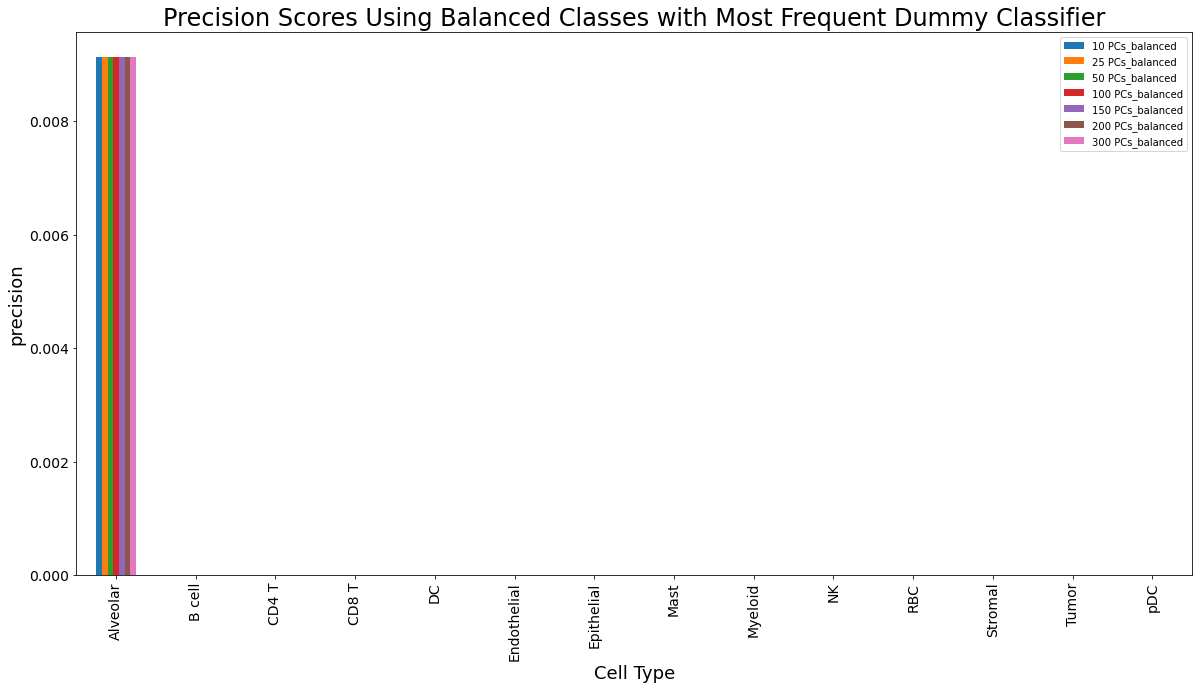

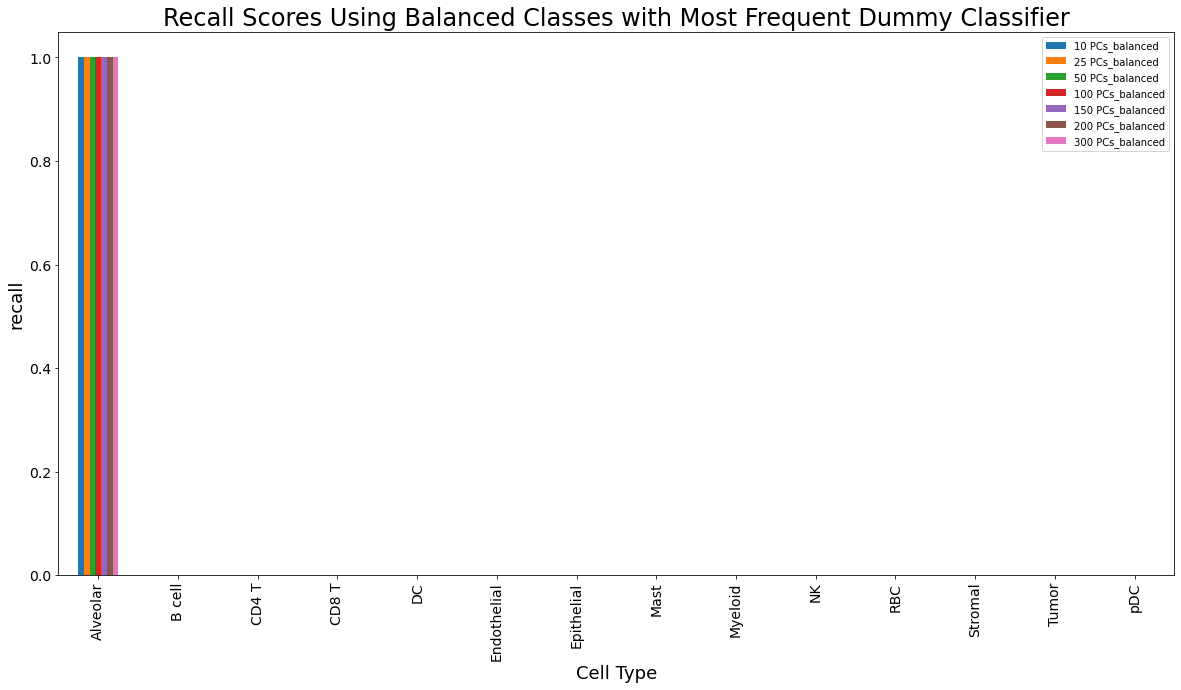

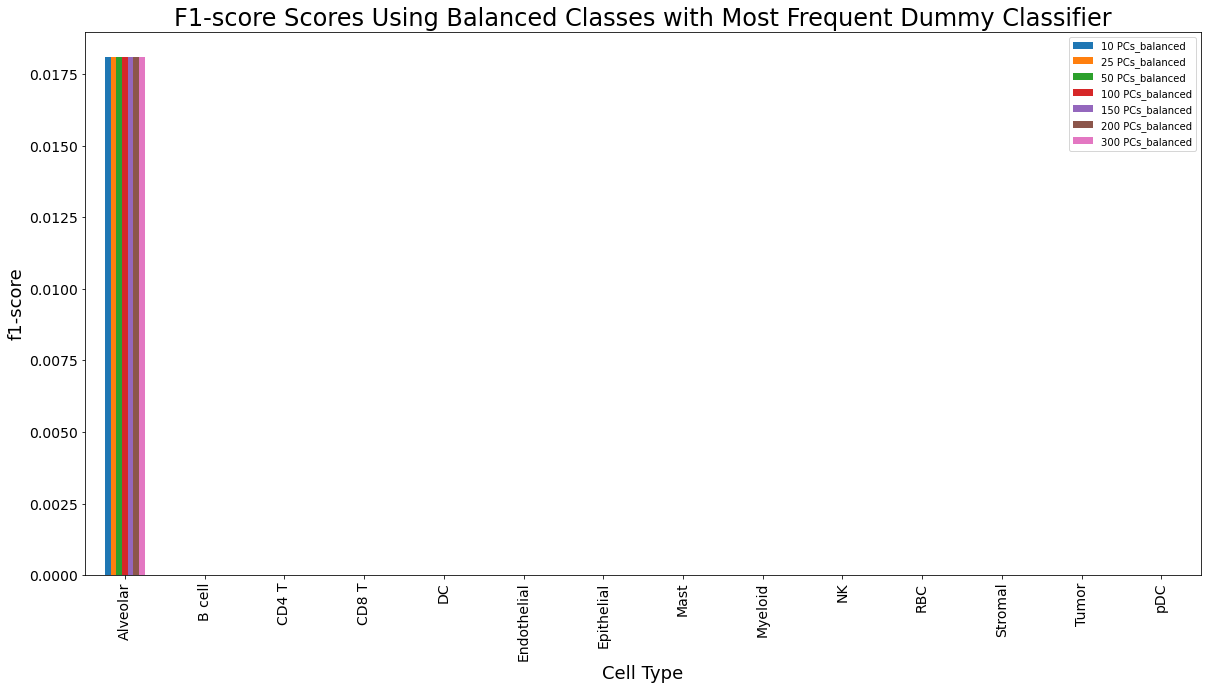

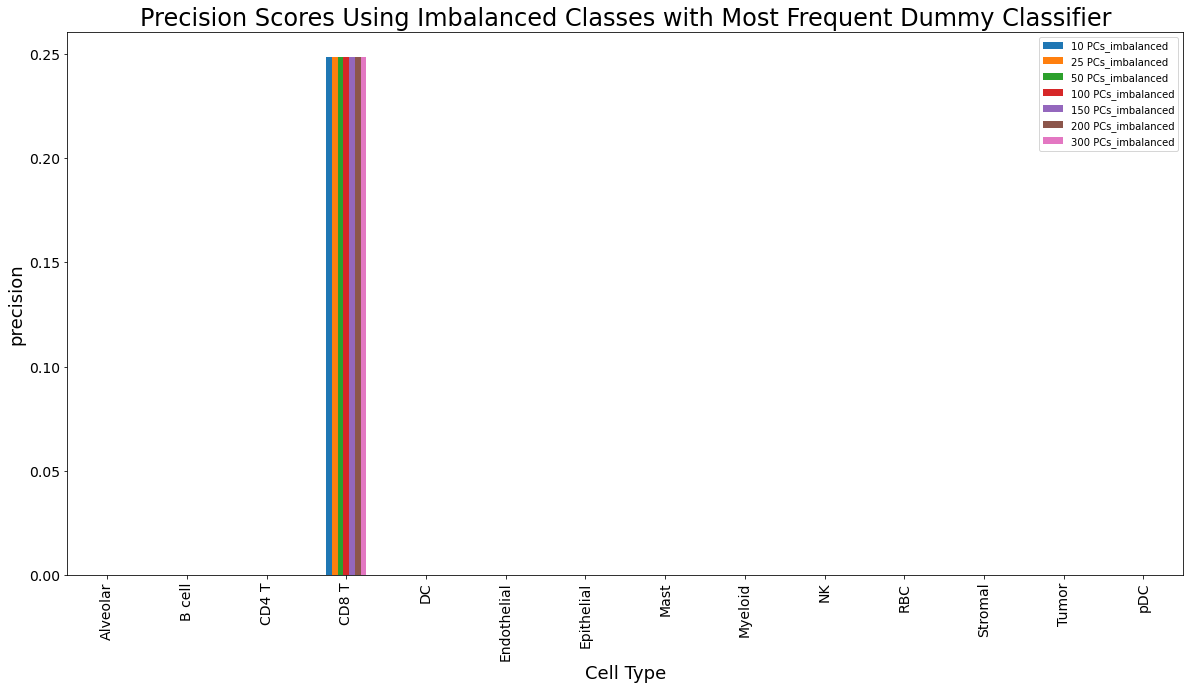

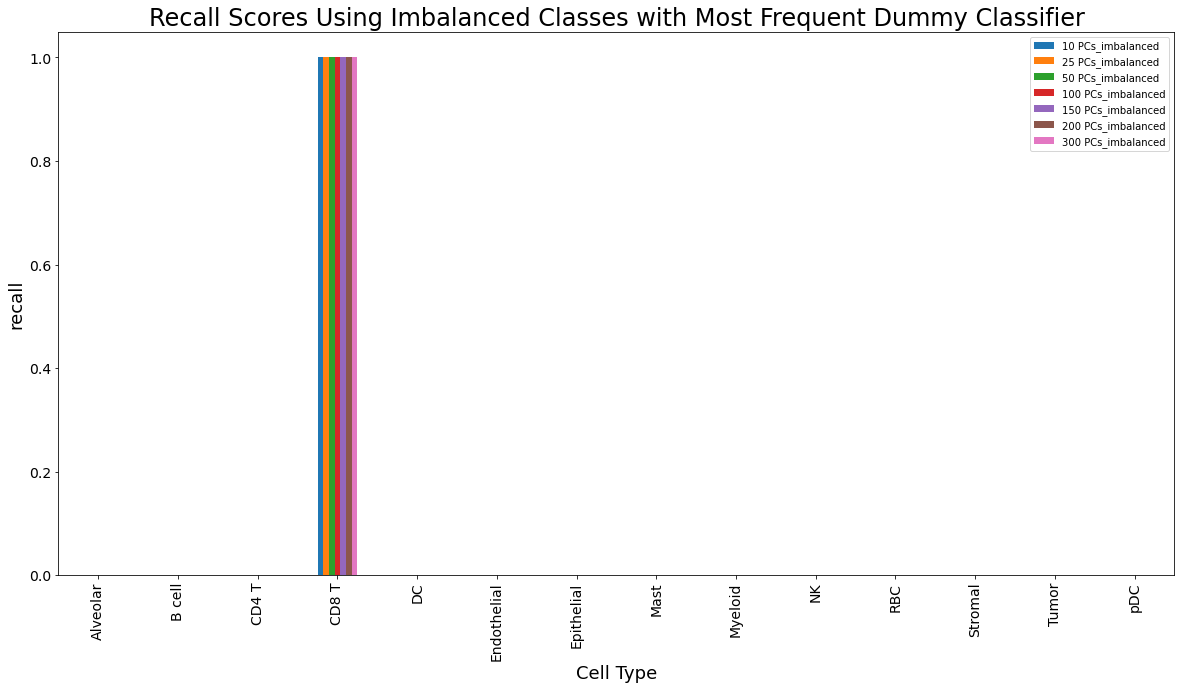

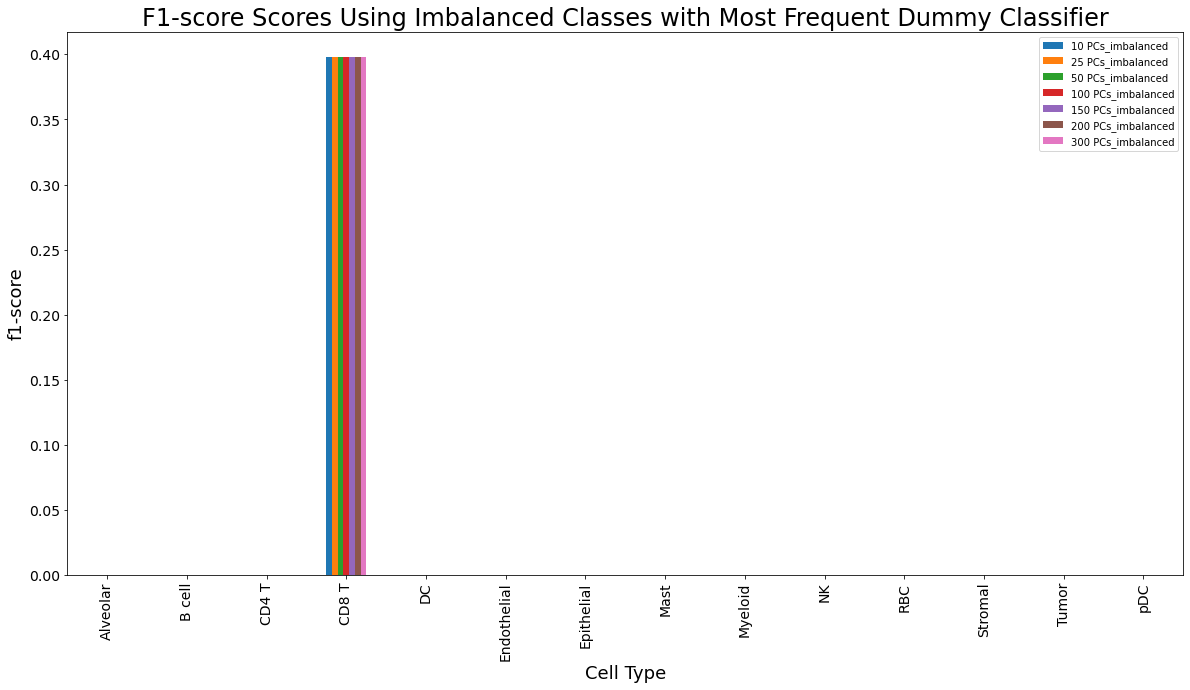

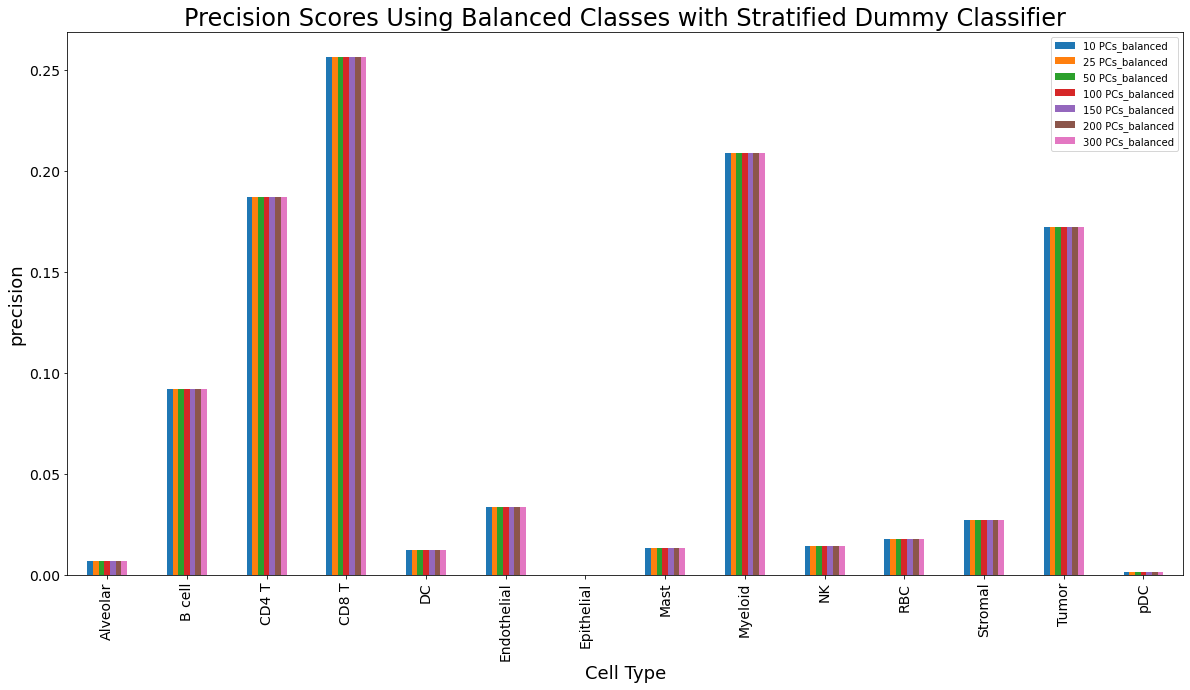

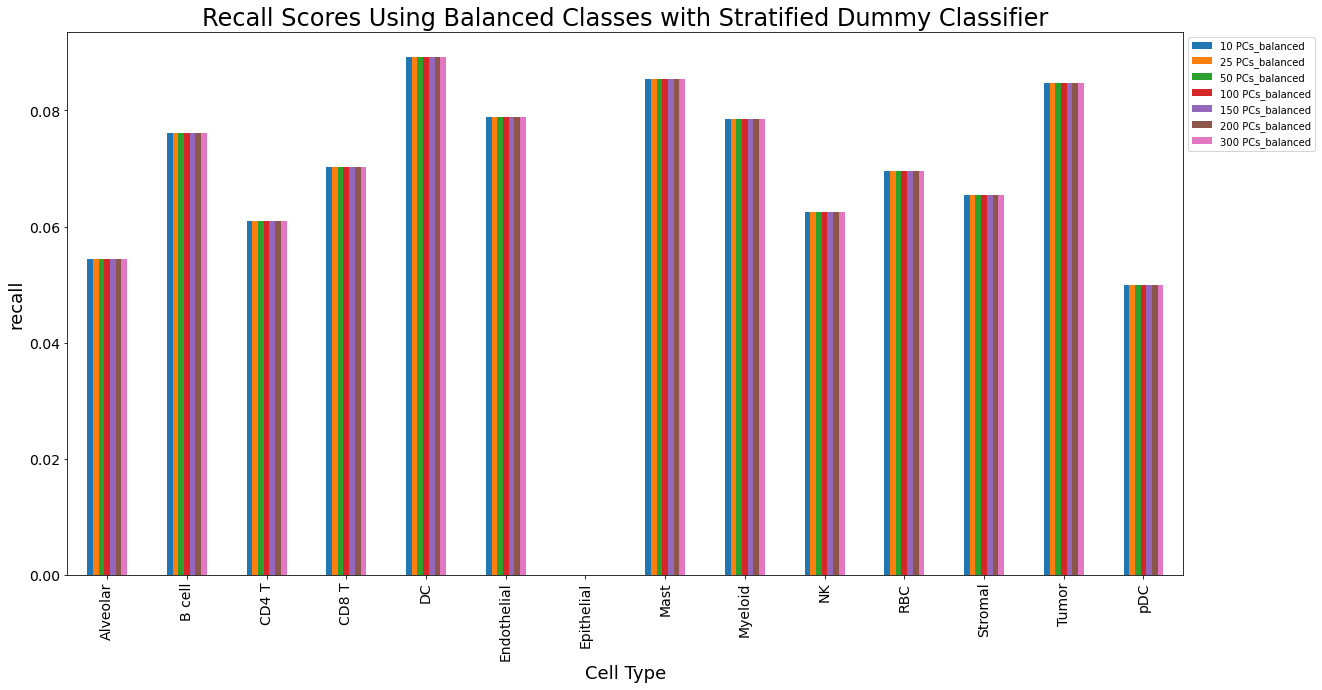

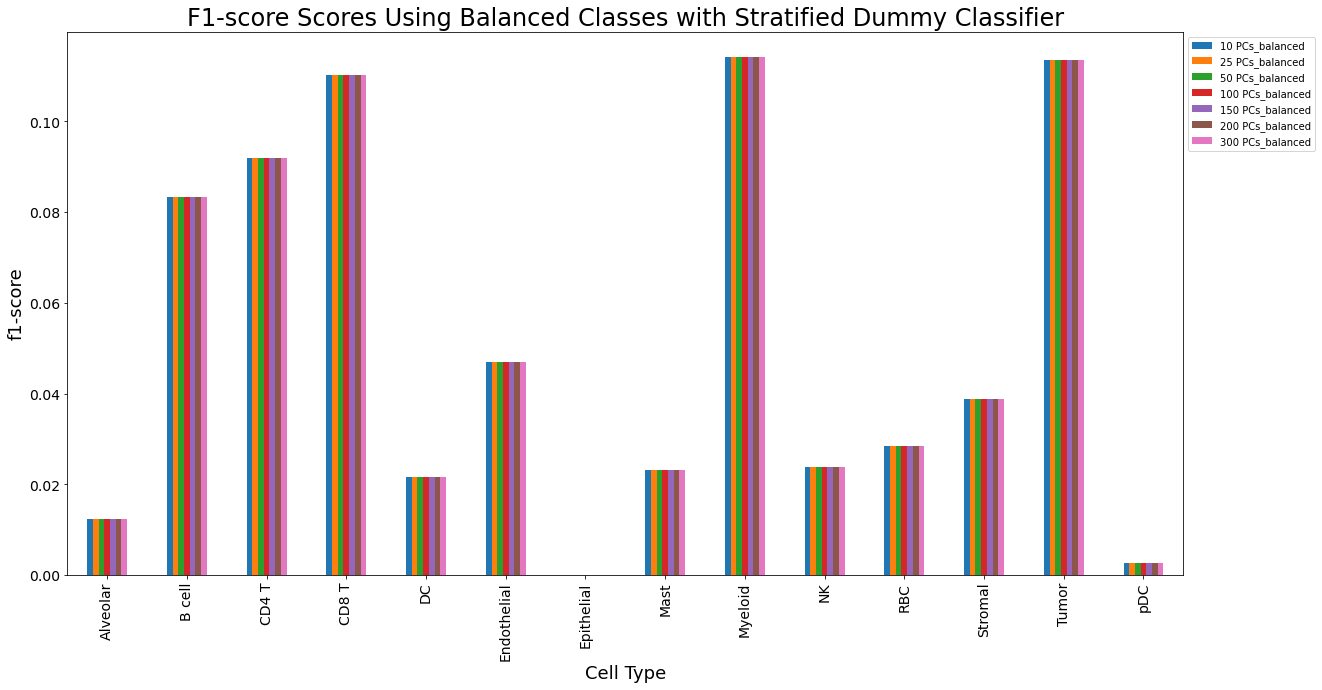

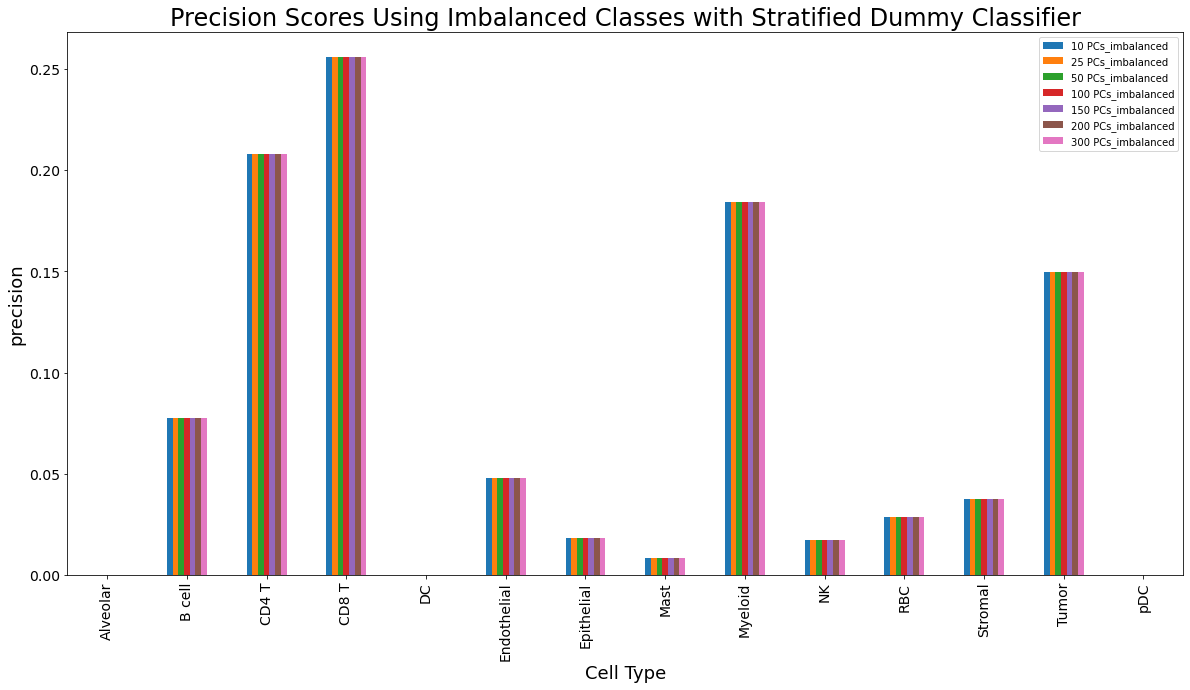

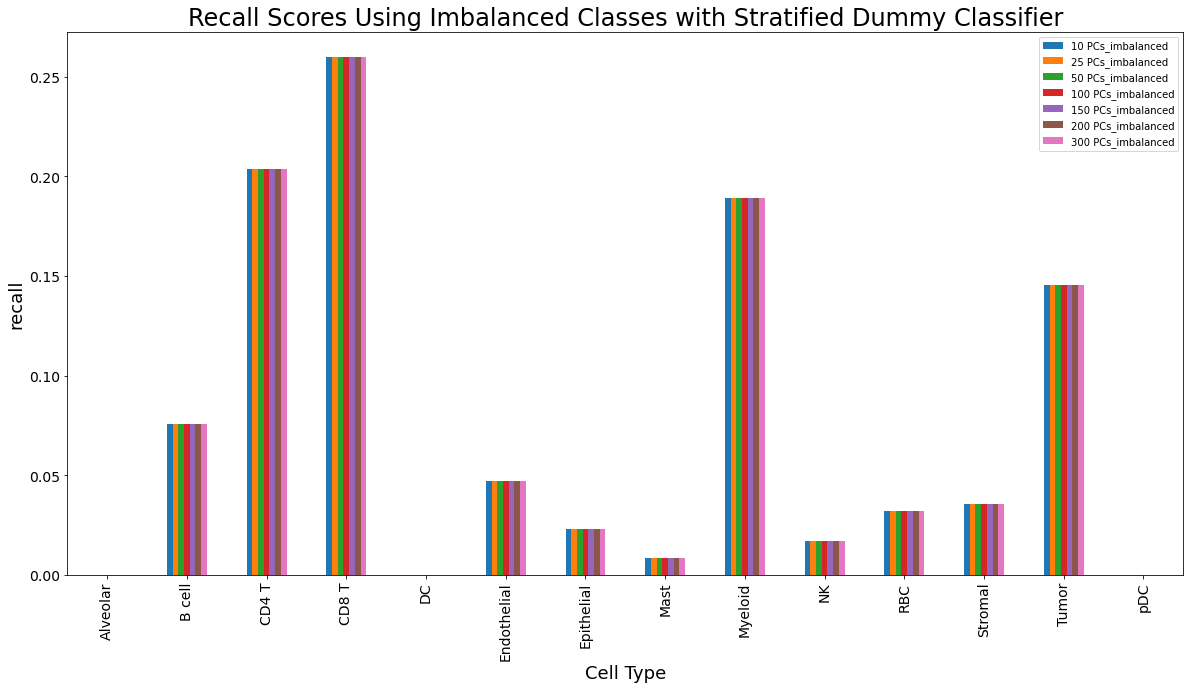

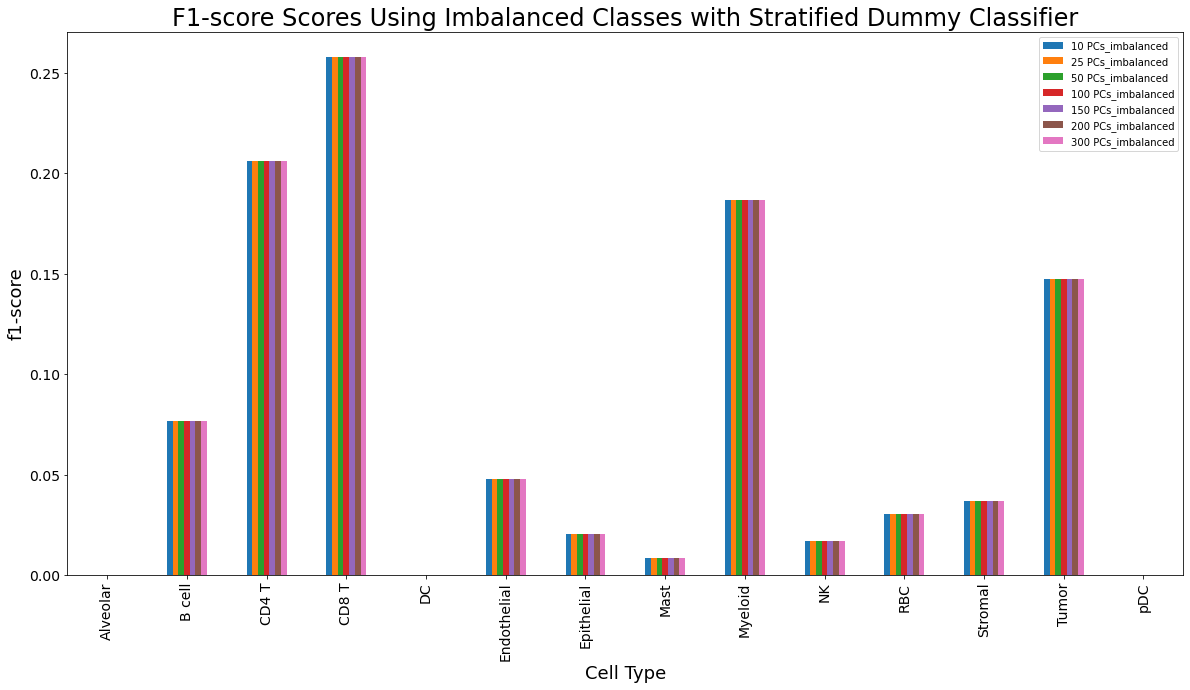

In [9]:
from sklearn.dummy import DummyClassifier

mostfrequent_dataframes = []
stratified_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    mostfrequent_dummy = DummyClassifier(strategy = "most_frequent", random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    mostfrequent_dataframes.append(generate_class_dataframe(mostfrequent_dummy, "Most Frequent Dummy Classifier", key, X_test, y_test))
    
    stratified_dummy = DummyClassifier(strategy = "stratified", random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    stratified_dataframes.append(generate_class_dataframe(stratified_dummy, "Stratified Dummy Classifier", key, X_test, y_test))
generate_summary_bar_plots(mostfrequent_dataframes, "Most Frequent Dummy Classifier", pc_train_test_dict.keys())
generate_summary_bar_plots(stratified_dataframes, "Stratified Dummy Classifier", pc_train_test_dict.keys())

### K Nearest Neighbors

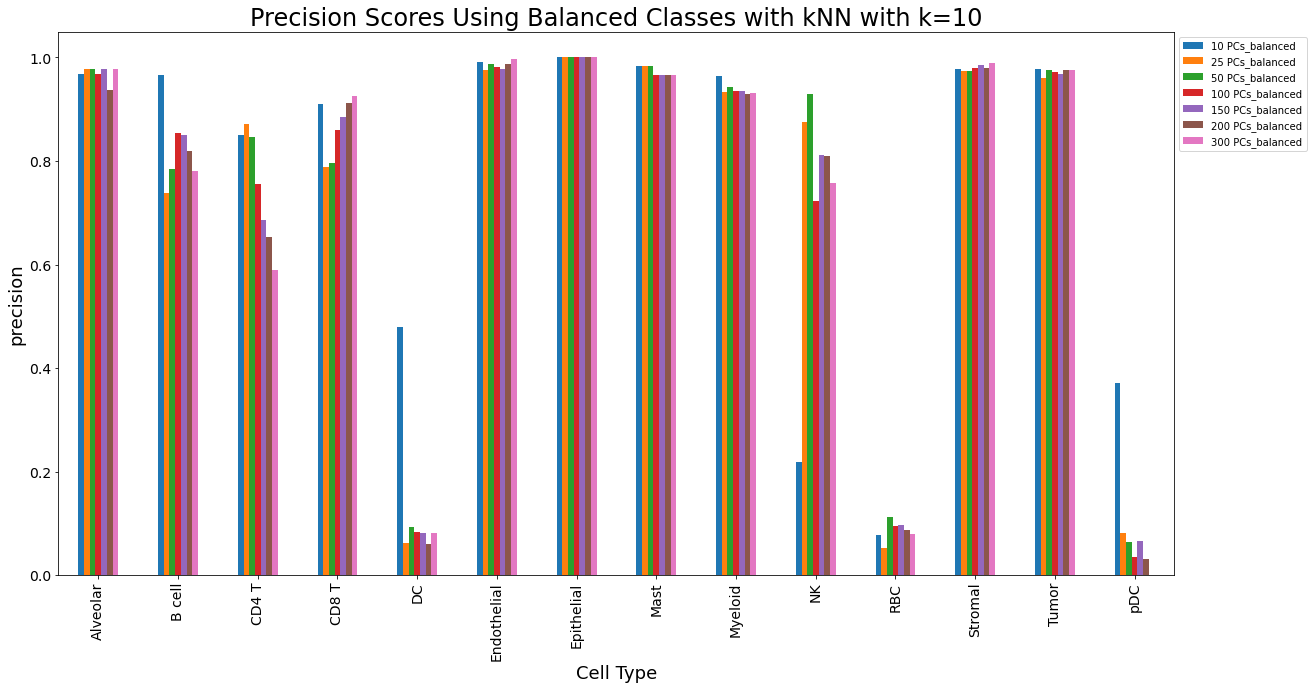

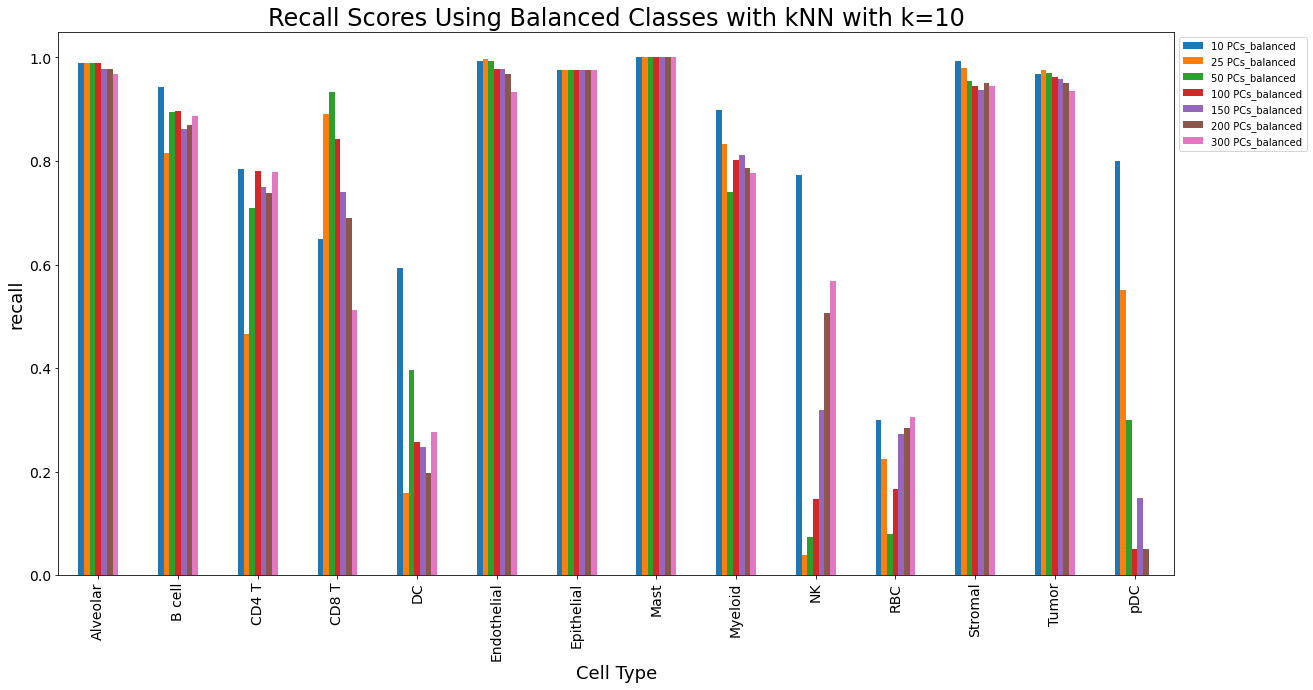

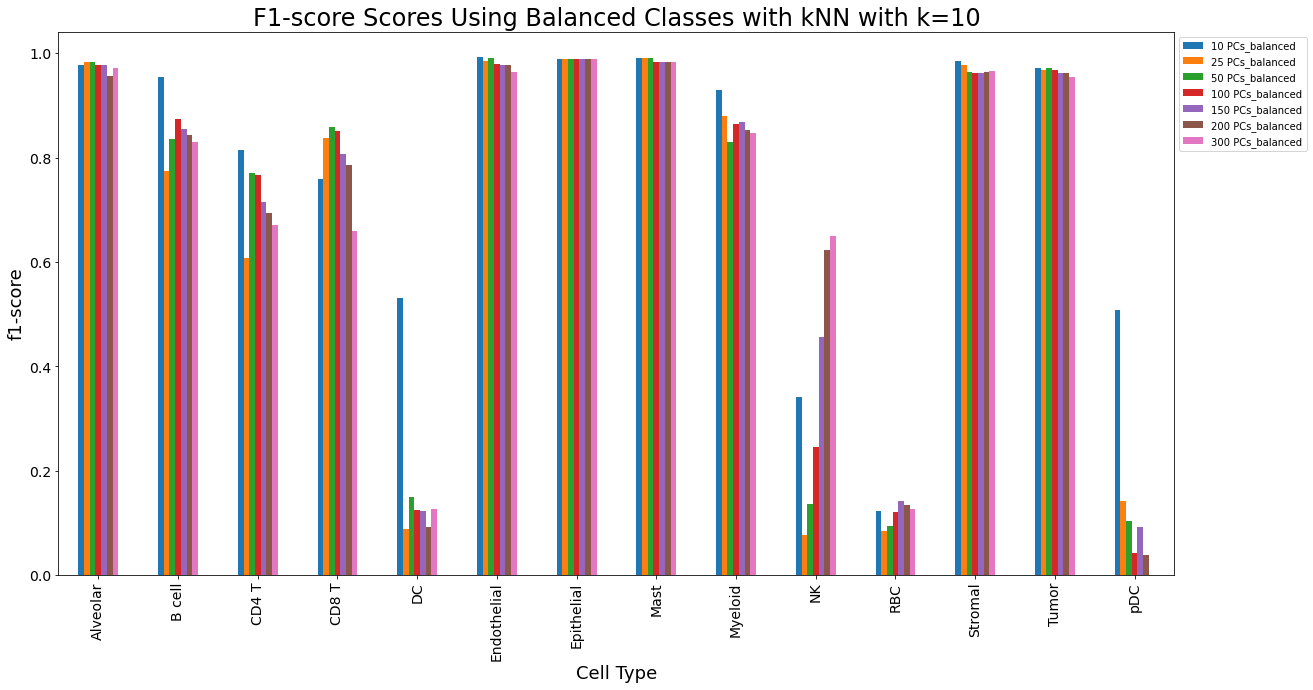

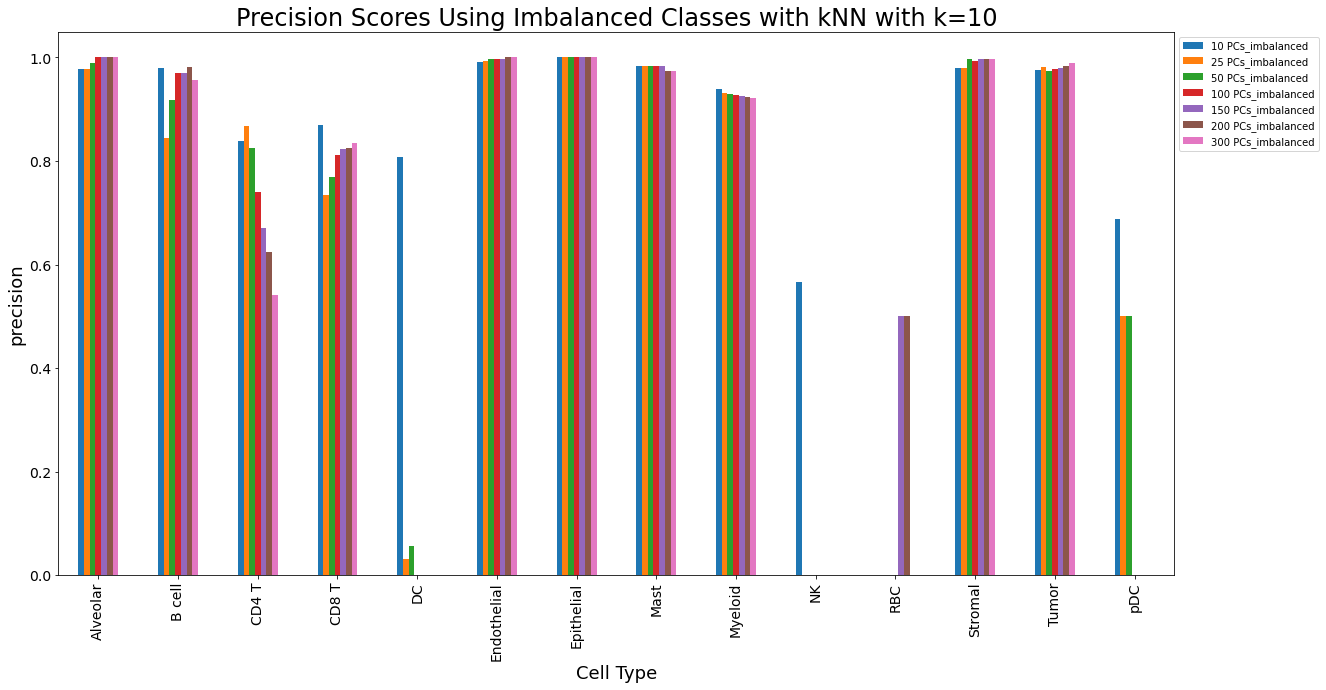

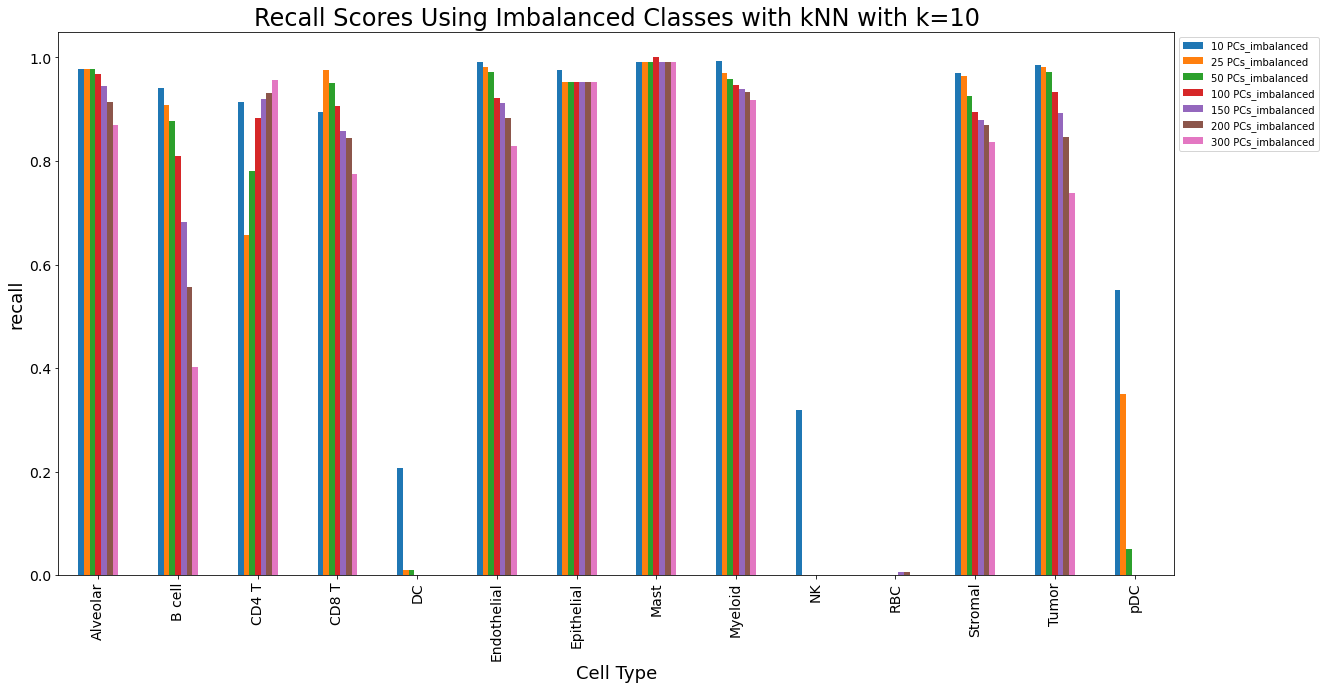

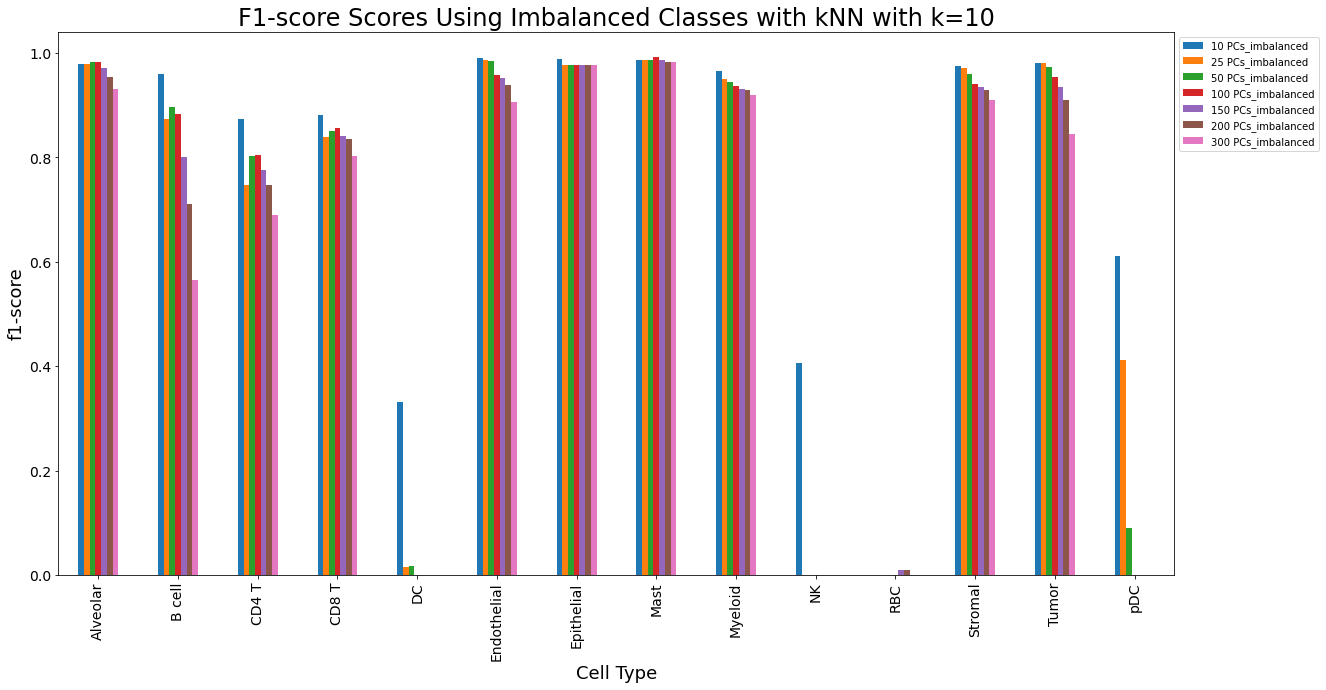

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train['type'])
    knn_dataframes.append(generate_class_dataframe(knn, "kNN with k=10", key, X_test, y_test))
generate_summary_bar_plots(knn_dataframes, "kNN with k=10", pc_train_test_dict.keys())

### Support Vector Machine Classifier

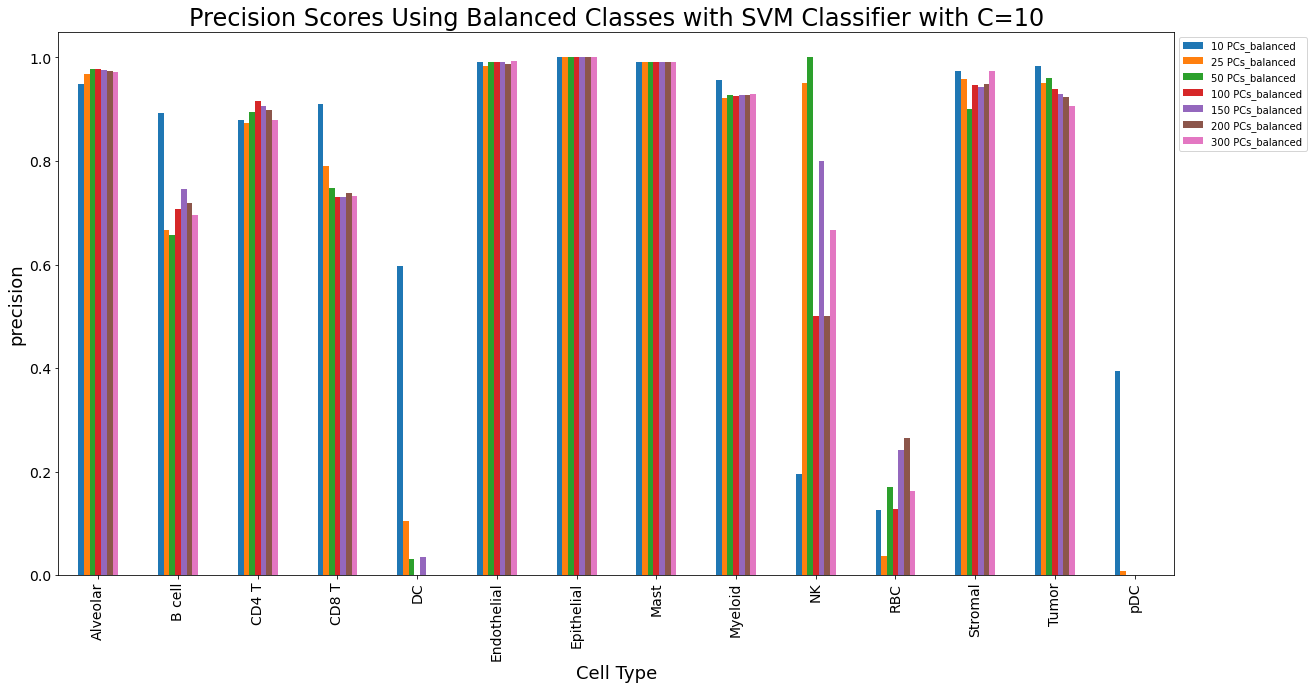

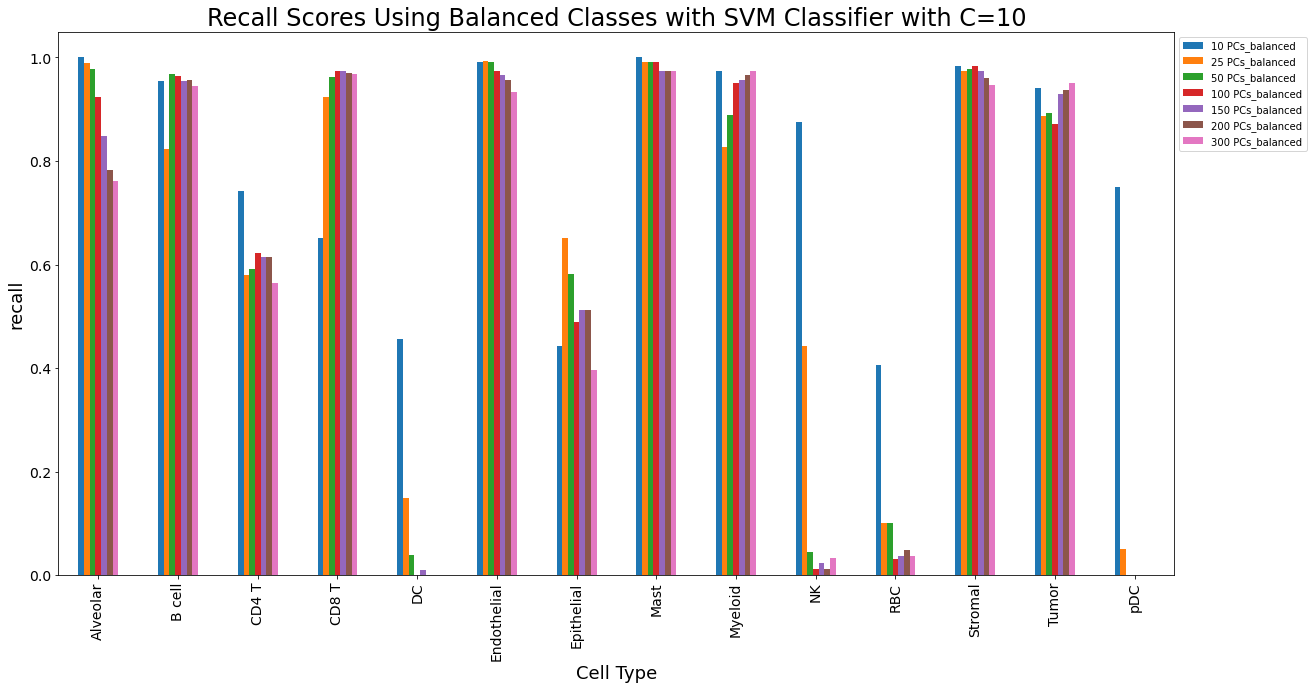

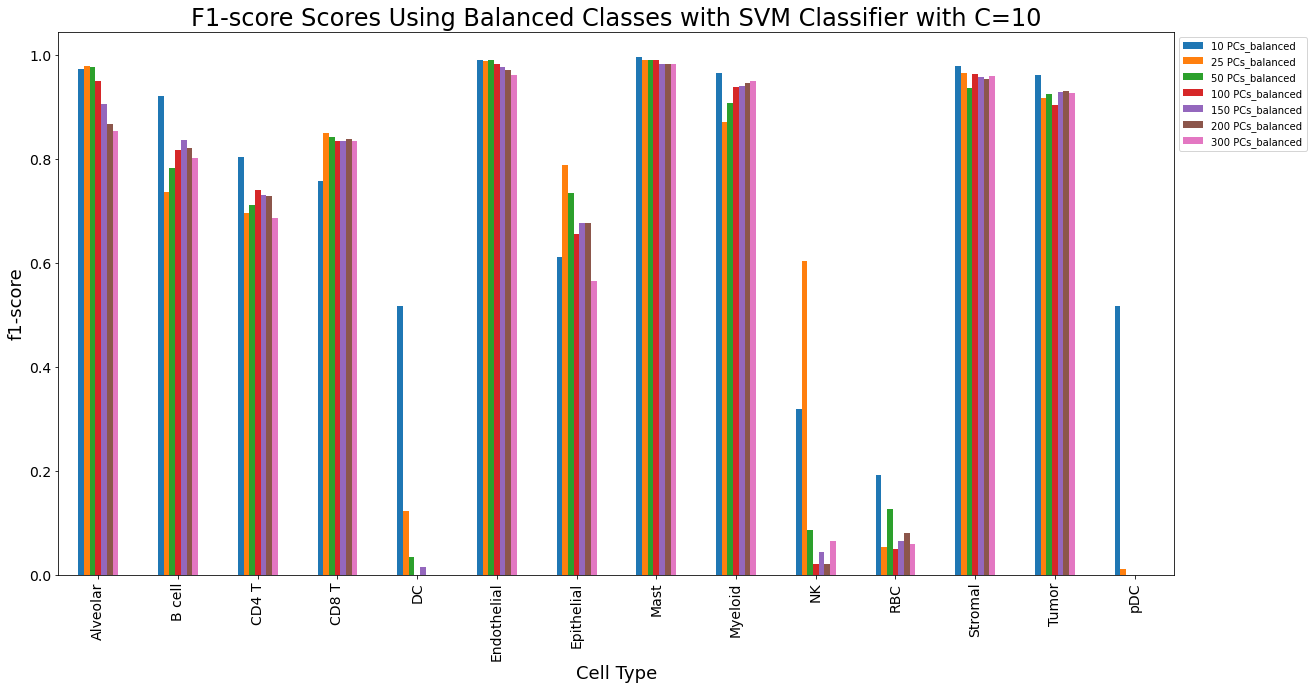

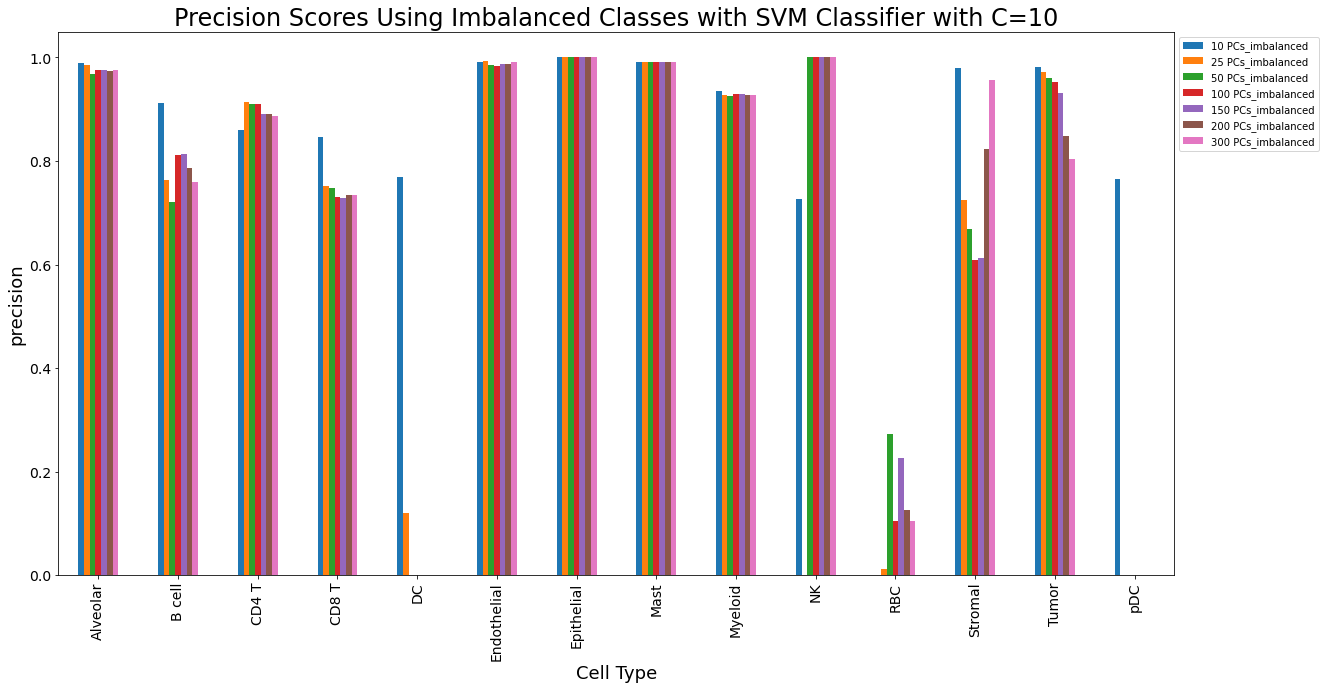

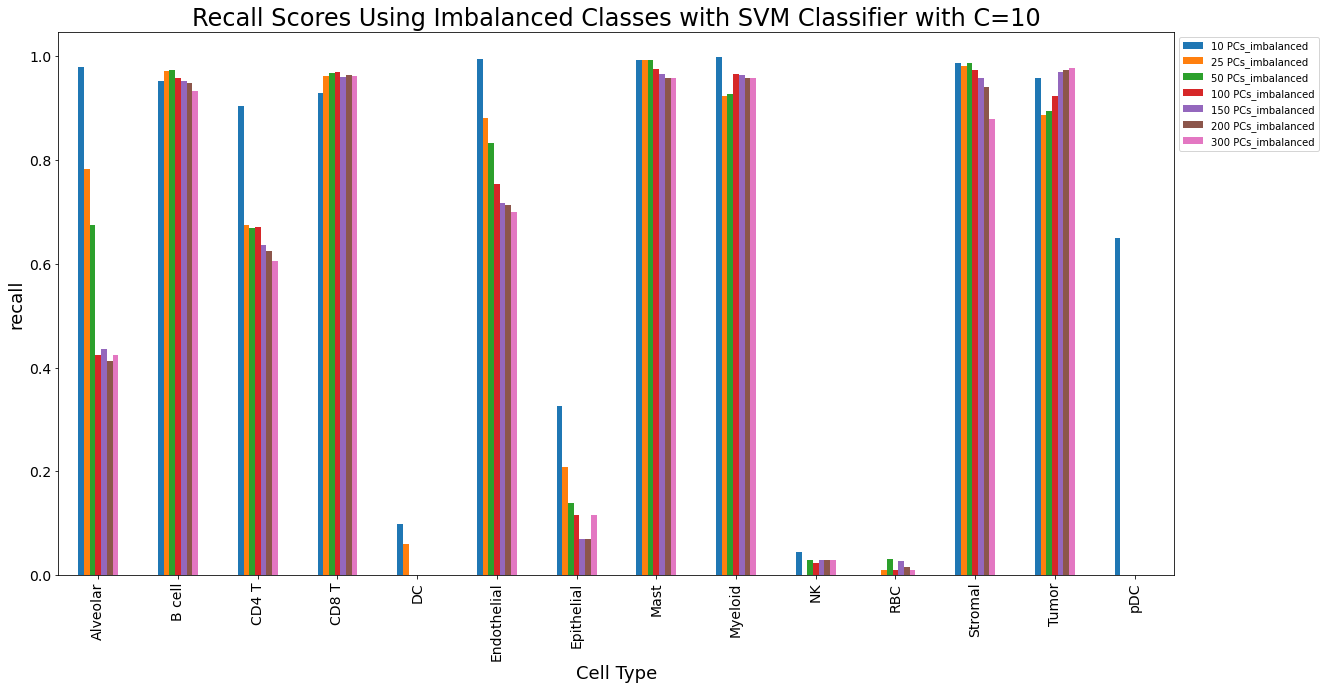

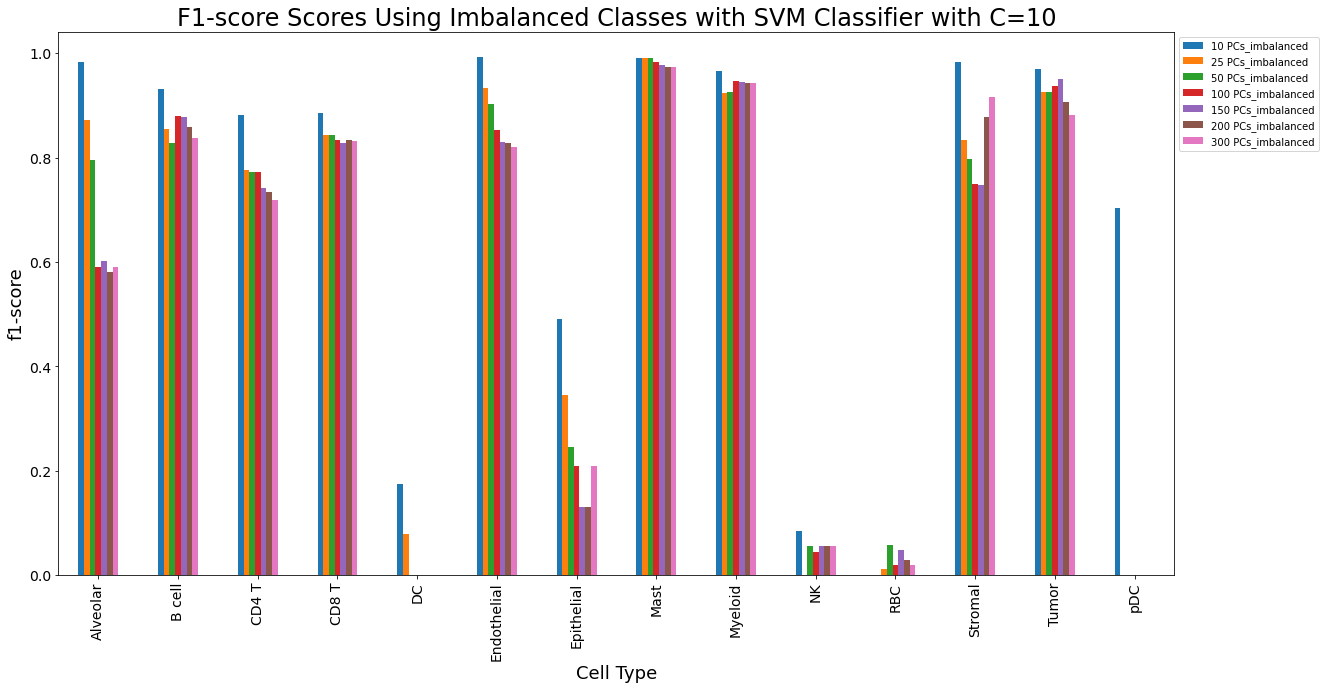

In [11]:
from sklearn.svm import SVC

svc_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    svc = SVC(C=10, random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    svc_dataframes.append(generate_class_dataframe(svc, "SVM Classifier with C=10", key, X_test, y_test))
generate_summary_bar_plots(svc_dataframes, "SVM Classifier with C=10", pc_train_test_dict.keys())

### Decision Tree

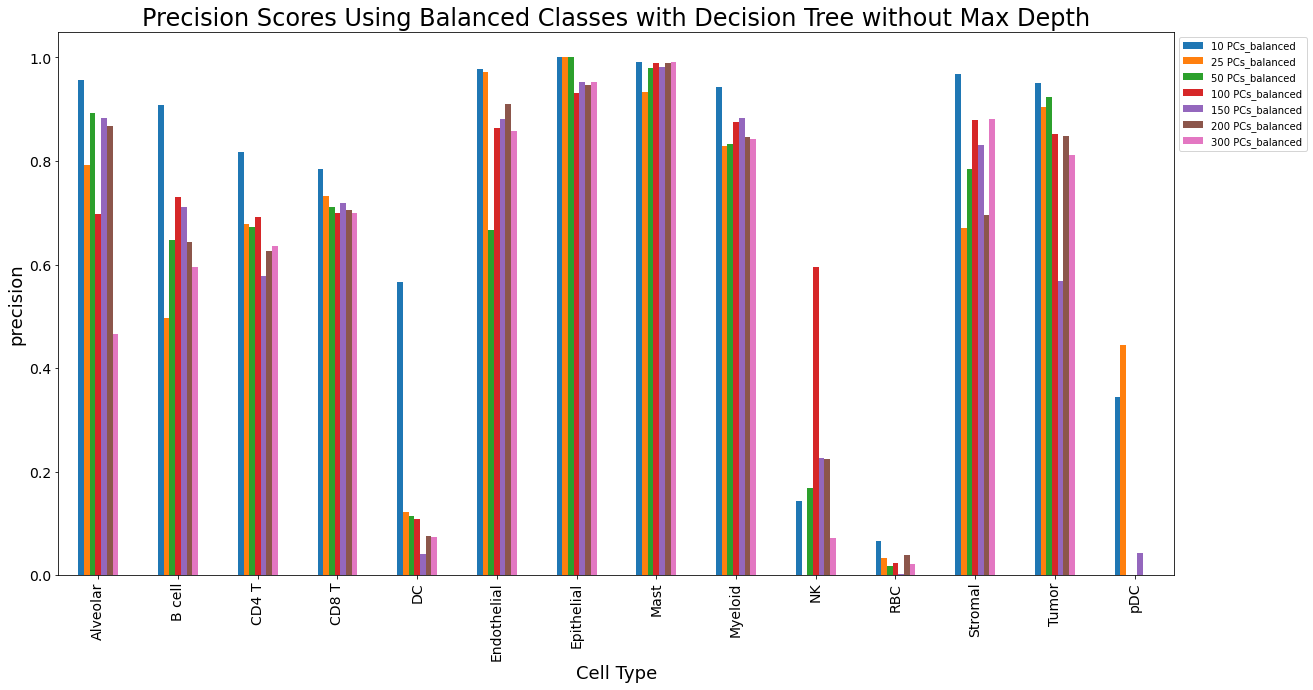

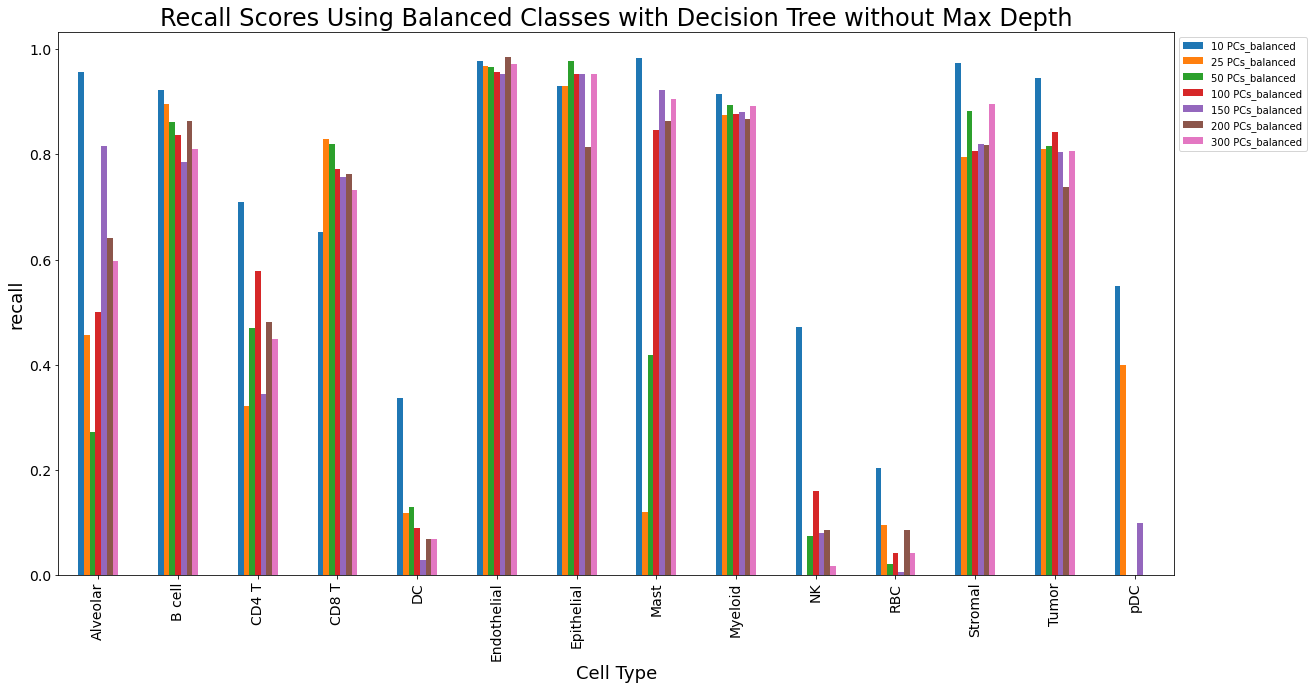

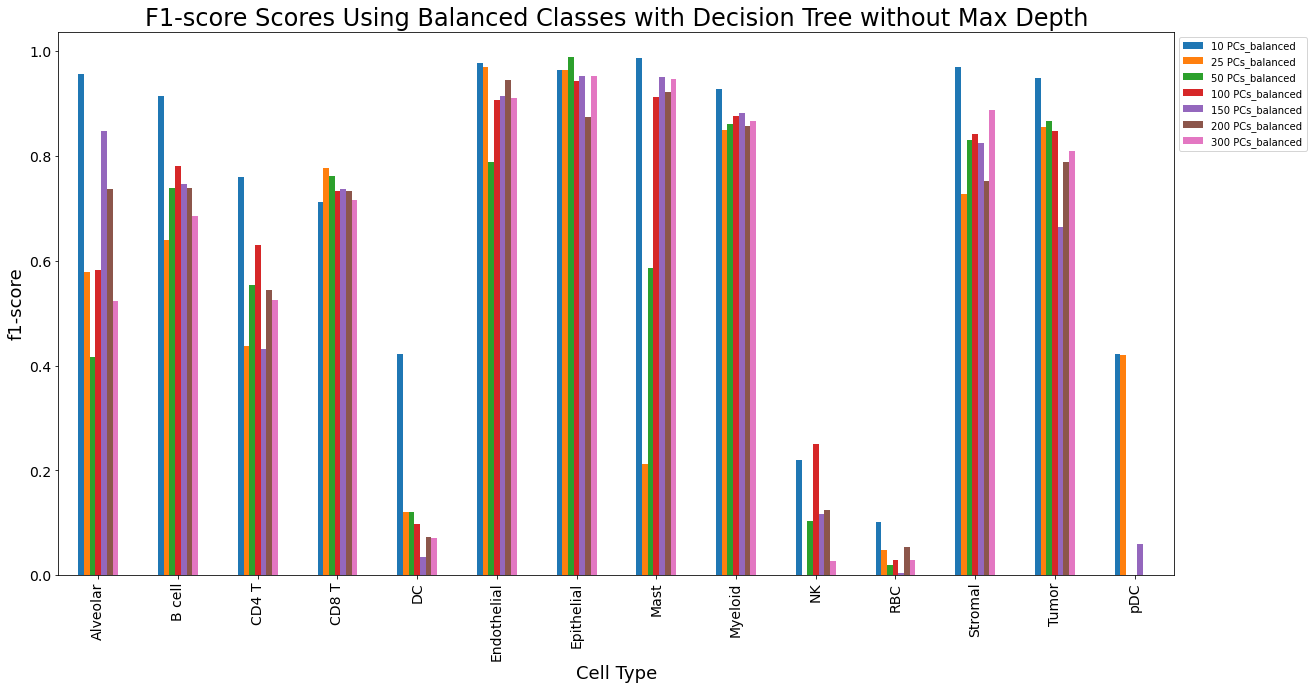

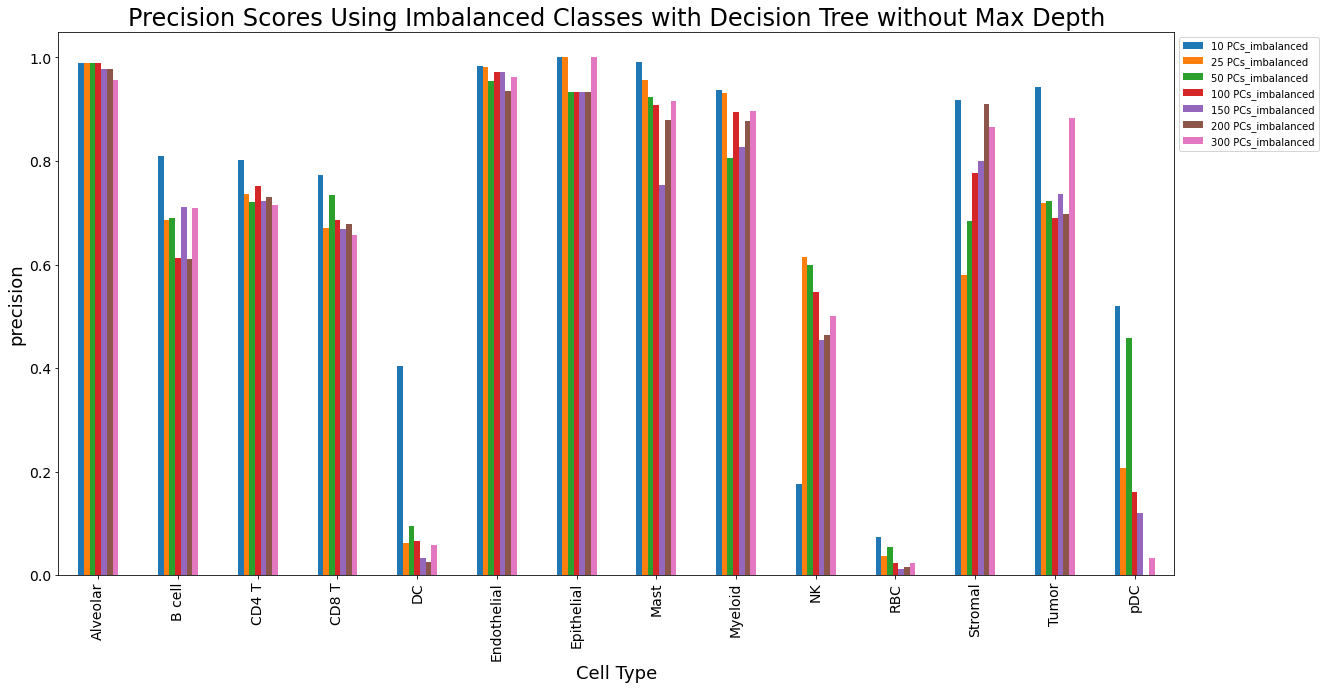

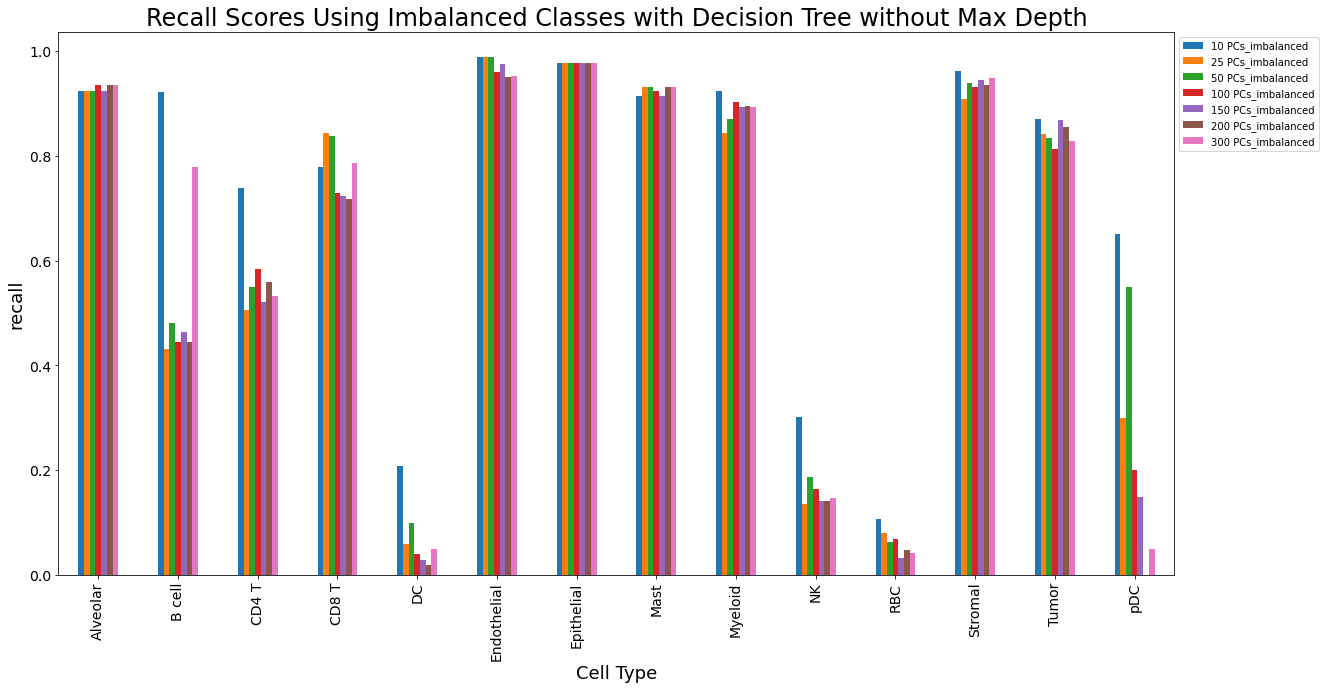

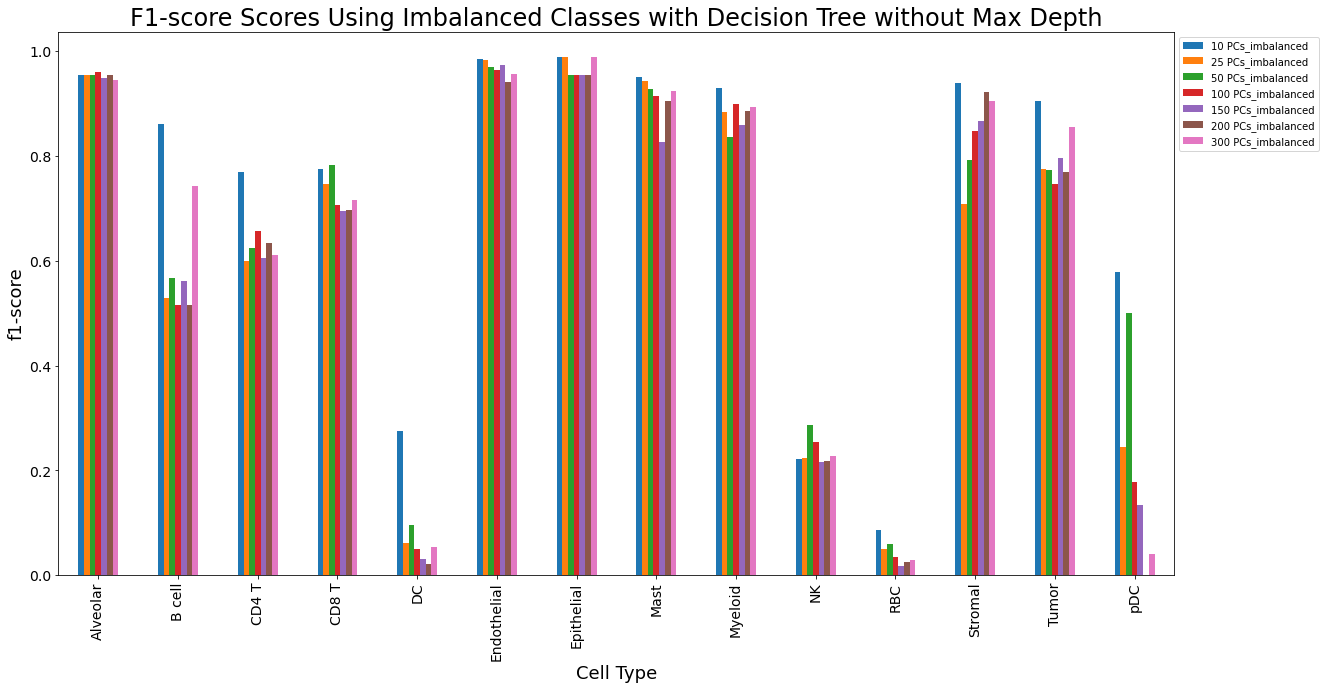

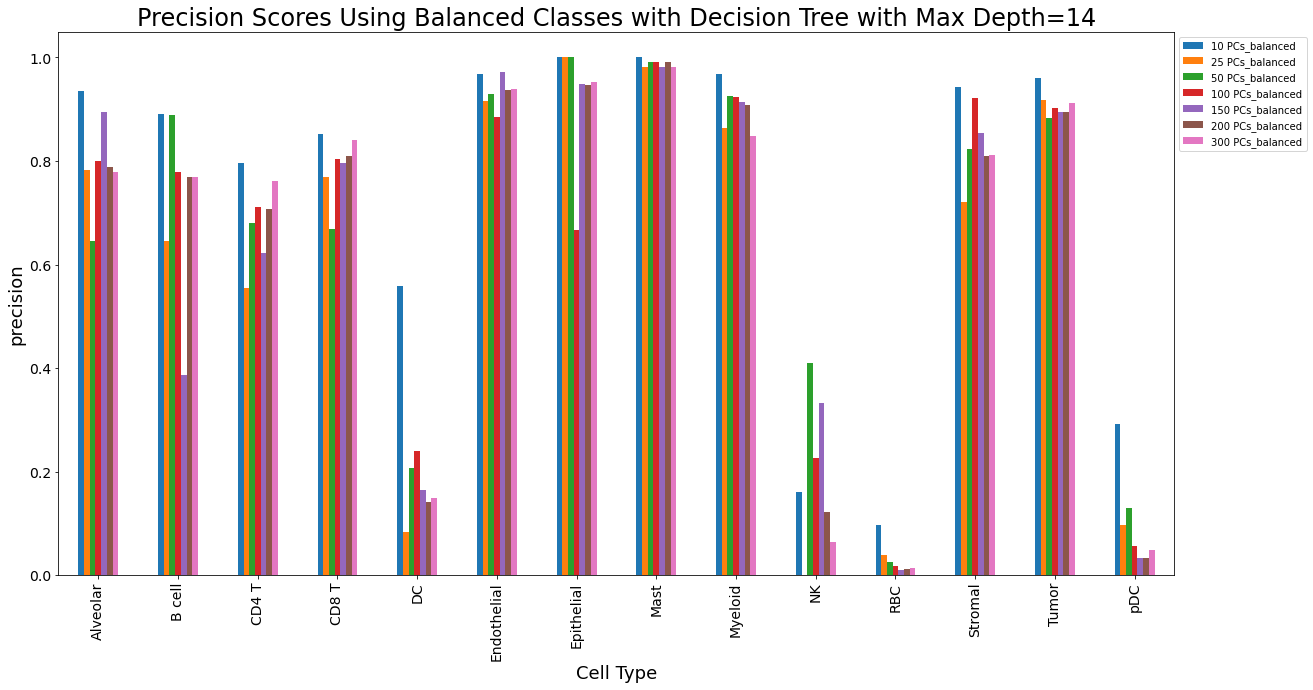

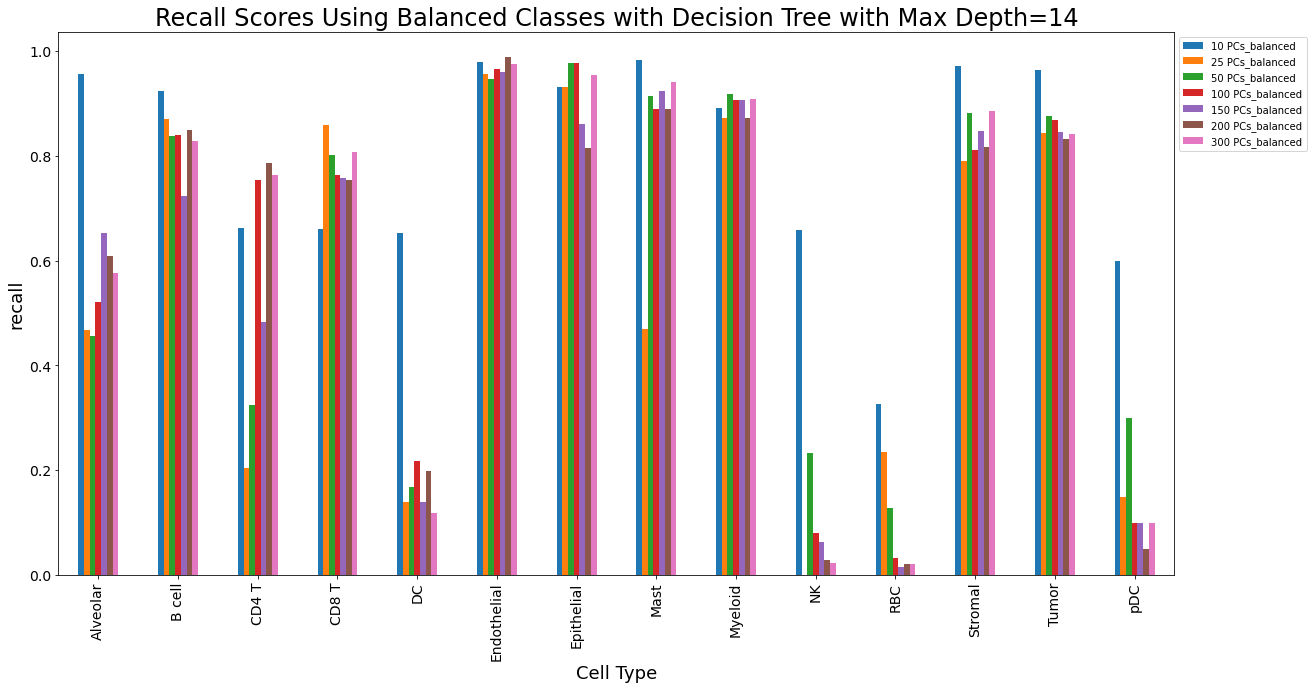

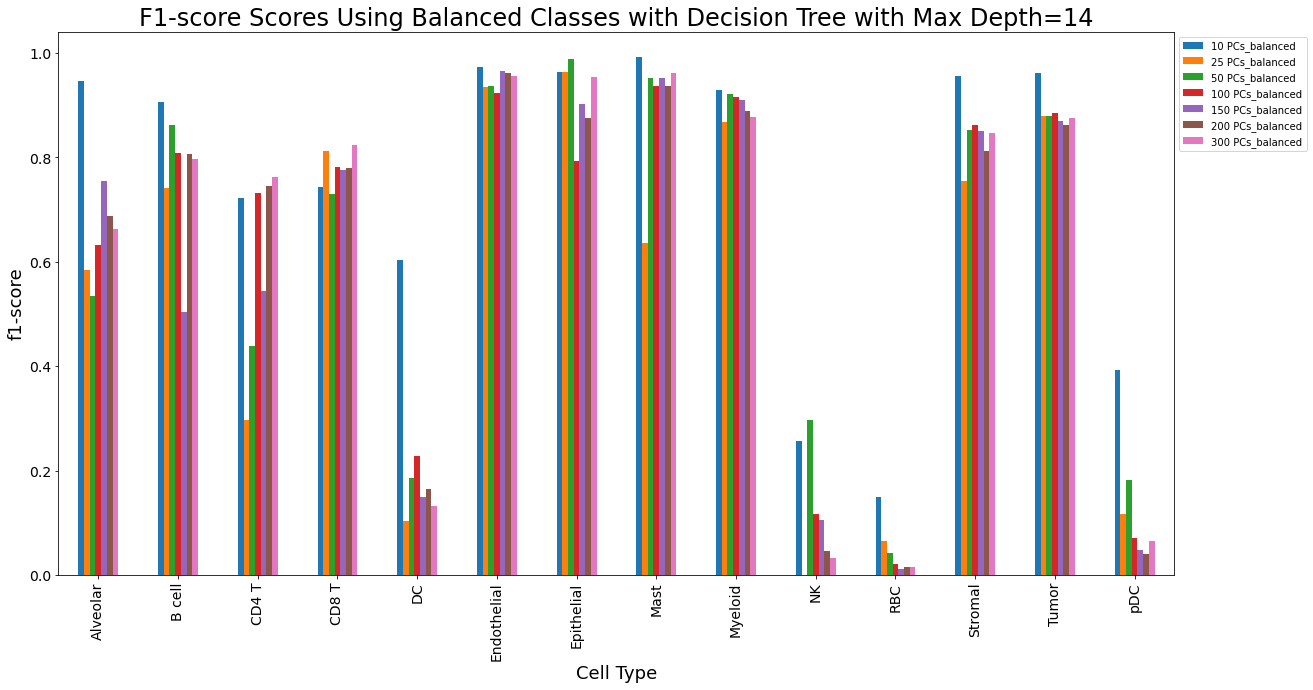

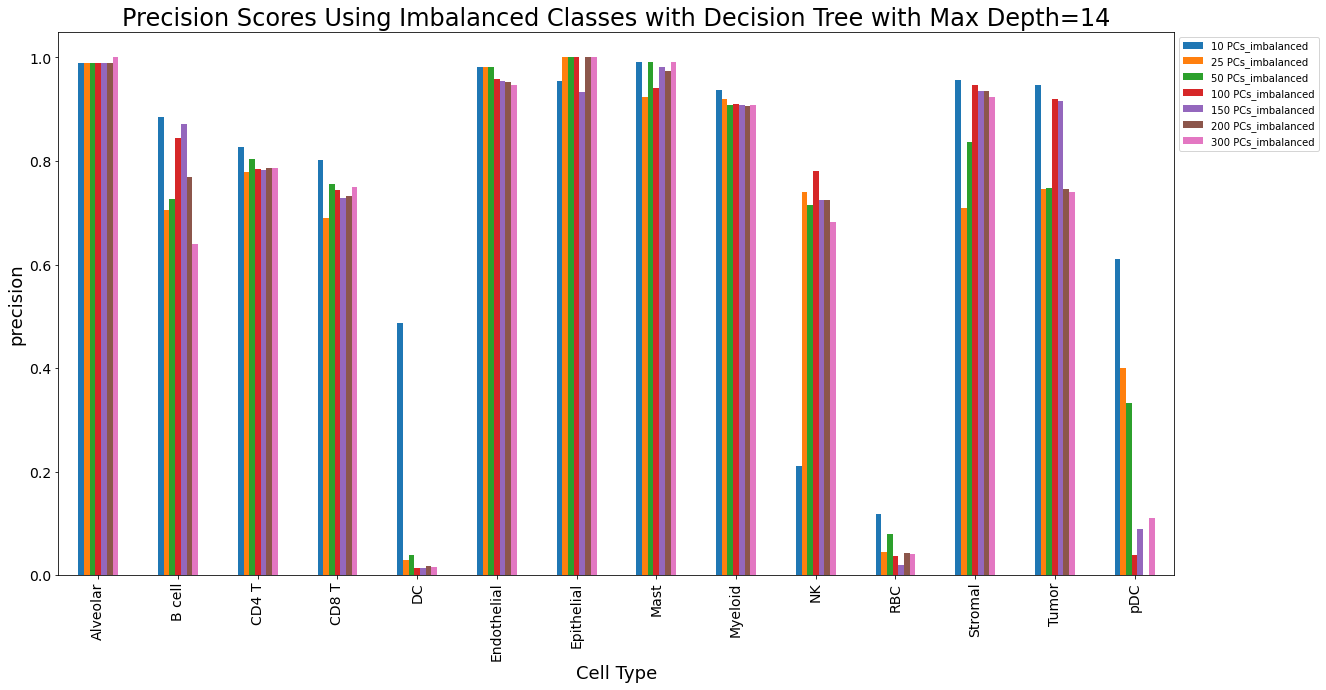

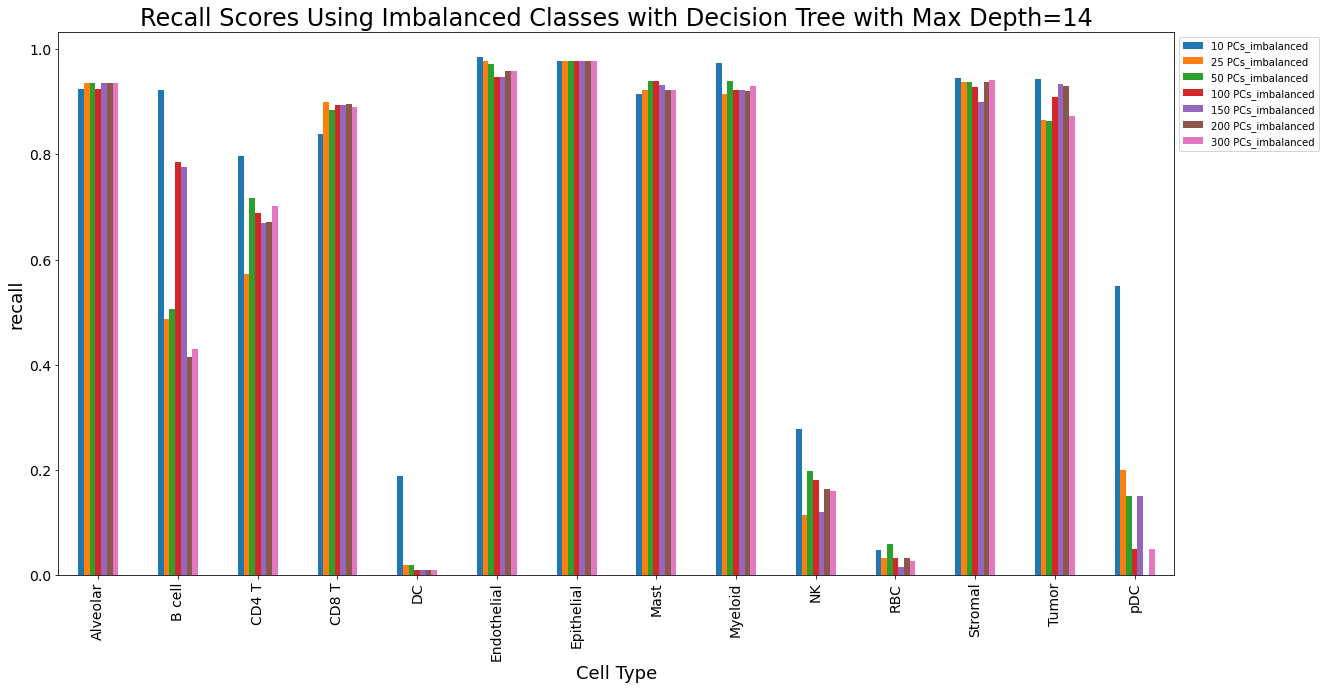

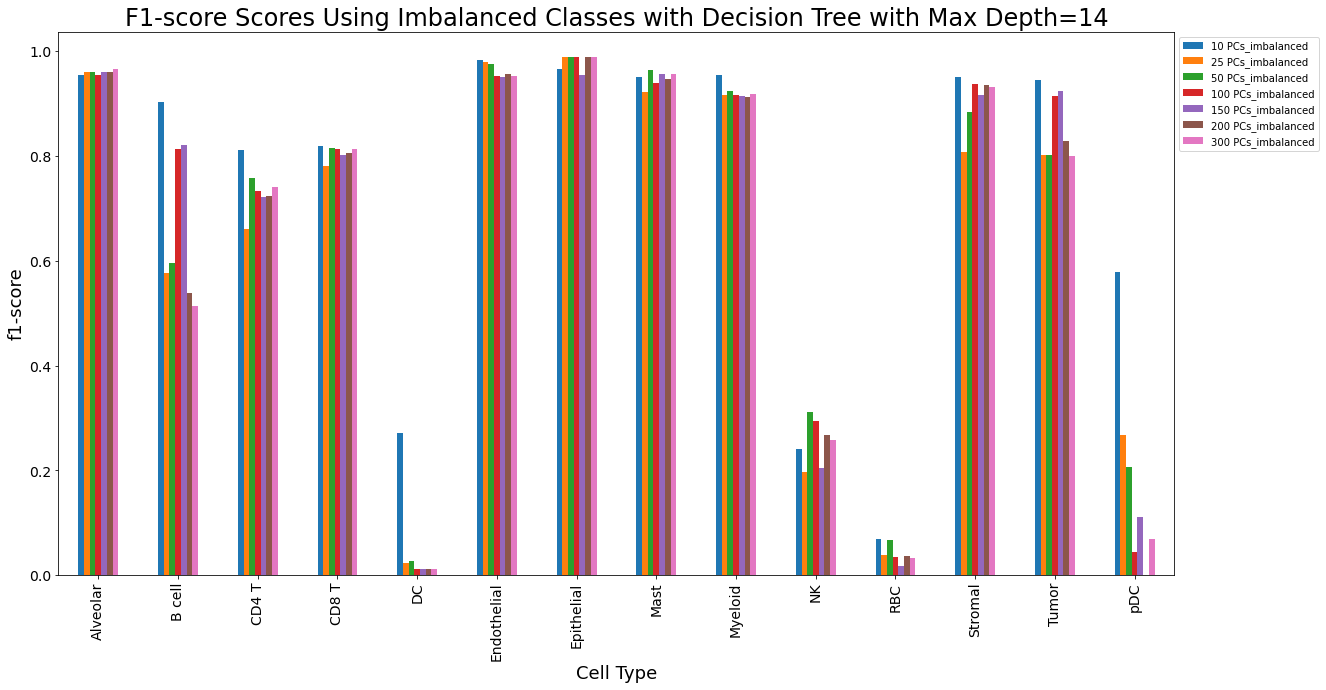

In [12]:
from sklearn.tree import DecisionTreeClassifier

decisiontree_nomd_dataframes = []
decisiontree_md_dataframes = []

for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    decisiontree_nomd = DecisionTreeClassifier(random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    decisiontree_nomd_dataframes.append(generate_class_dataframe(decisiontree_nomd, "Decision Tree without Max Depth", key, X_test, y_test))

    decisiontree_md = DecisionTreeClassifier(max_depth=len(y_train['type'].unique()), random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    decisiontree_md_dataframes.append(generate_class_dataframe(decisiontree_md, "Decision Tree with Max Depth={}".format(len(y_train['type'].unique())), key, X_test, y_test))
generate_summary_bar_plots(decisiontree_nomd_dataframes, "Decision Tree without Max Depth", pc_train_test_dict.keys())
generate_summary_bar_plots(decisiontree_md_dataframes, "Decision Tree with Max Depth={}".format(len(y_train['type'].unique())), pc_train_test_dict.keys())

### Gradient-boosted Decision Tree

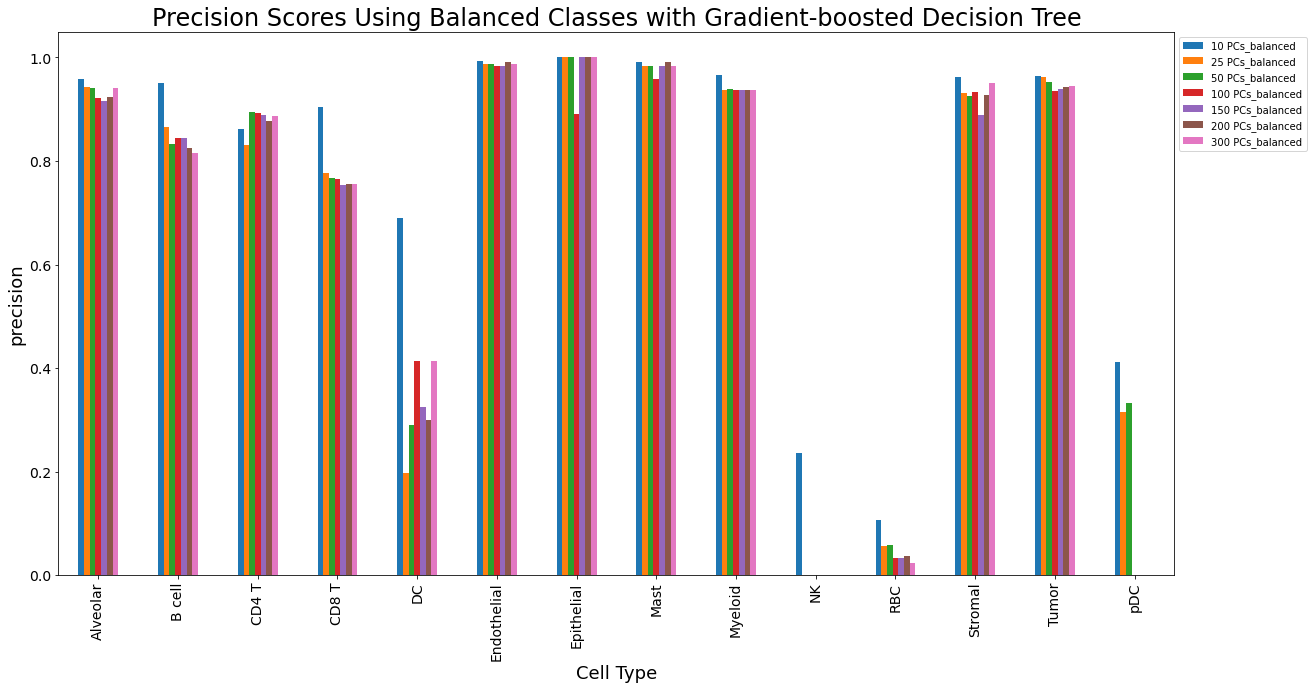

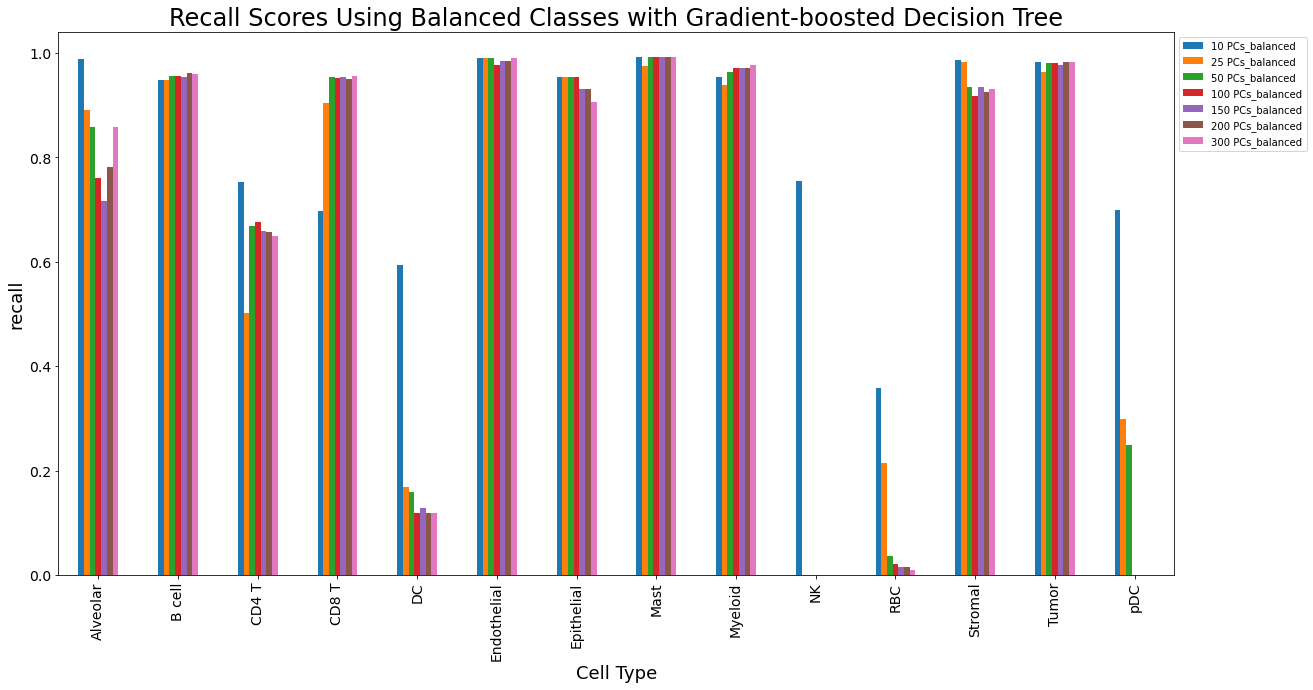

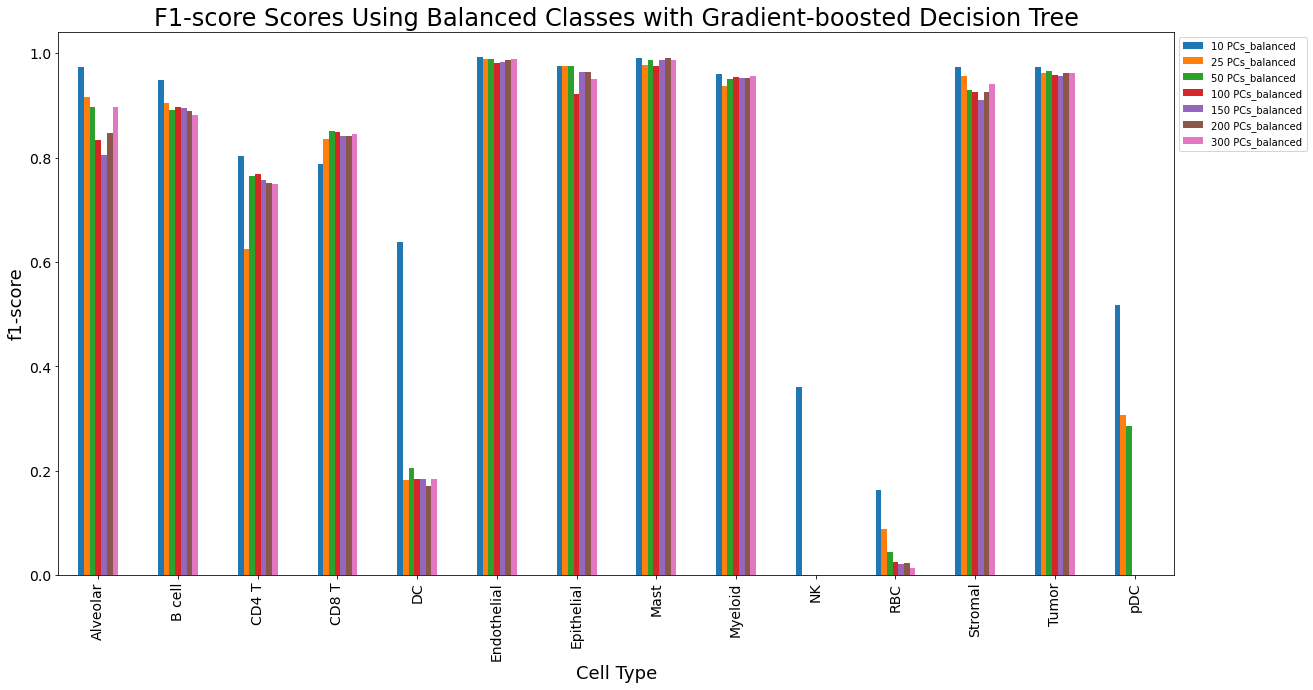

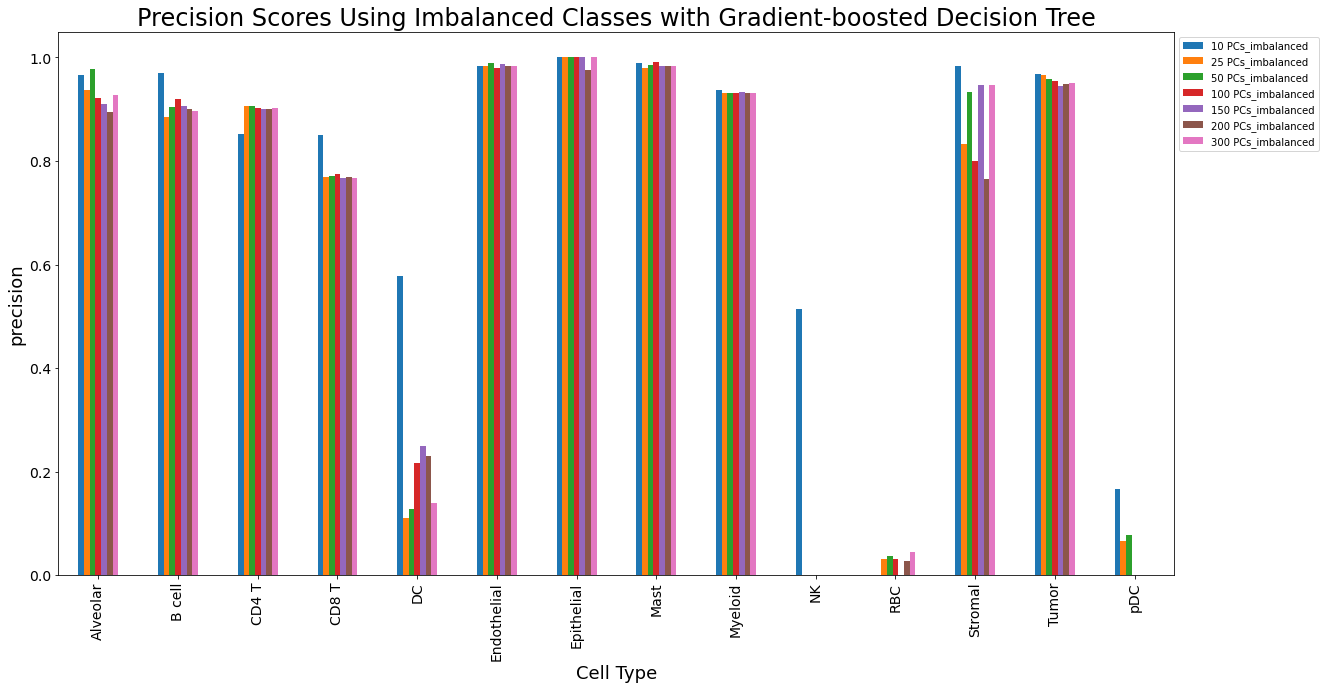

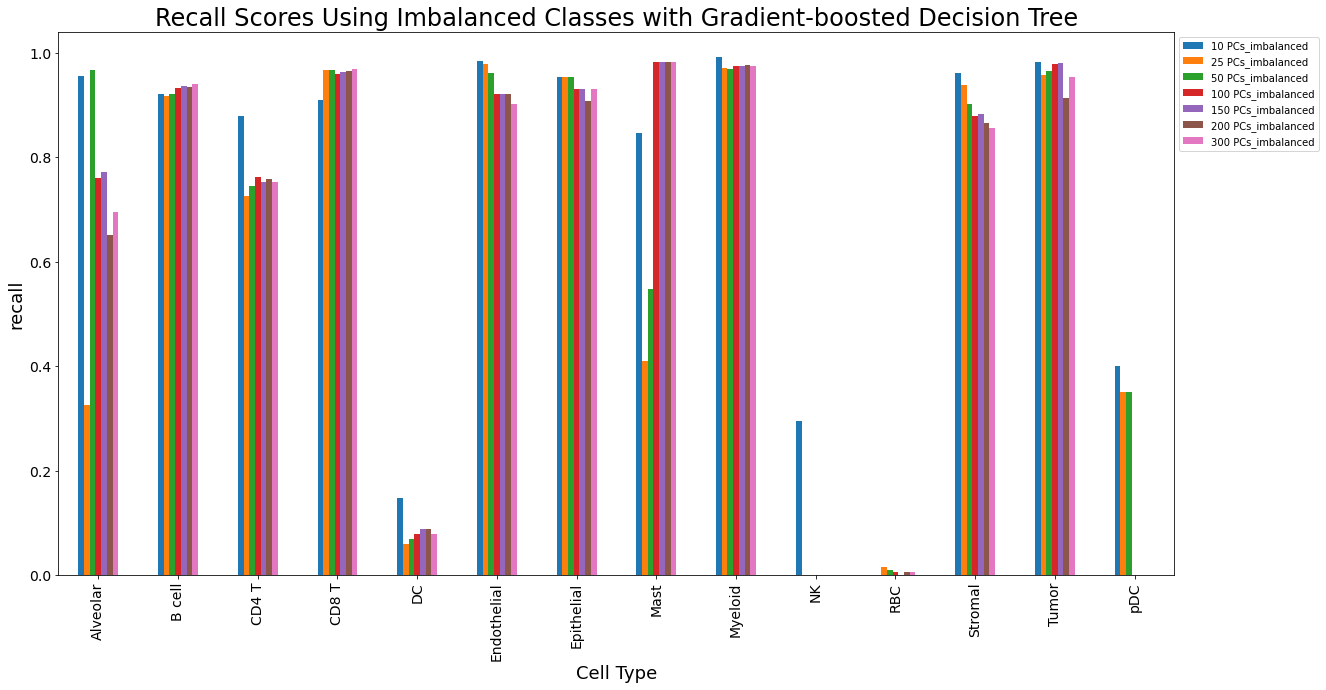

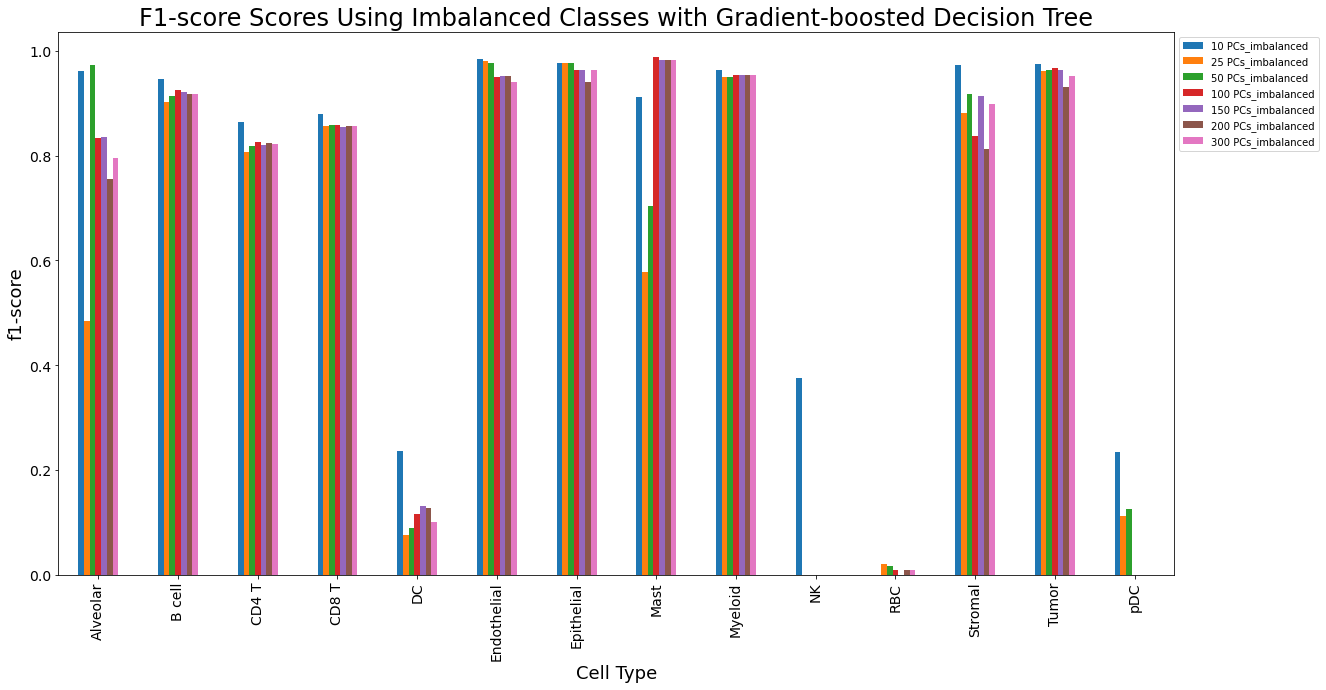

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    gbdt = GradientBoostingClassifier(random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    gbdt_dataframes.append(generate_class_dataframe(gbdt, "Gradient-boosted Decision Tree", key, X_test, y_test))
generate_summary_bar_plots(gbdt_dataframes, "Gradient-boosted Decision Tree", pc_train_test_dict.keys())

### Naive Bayes Classifiers

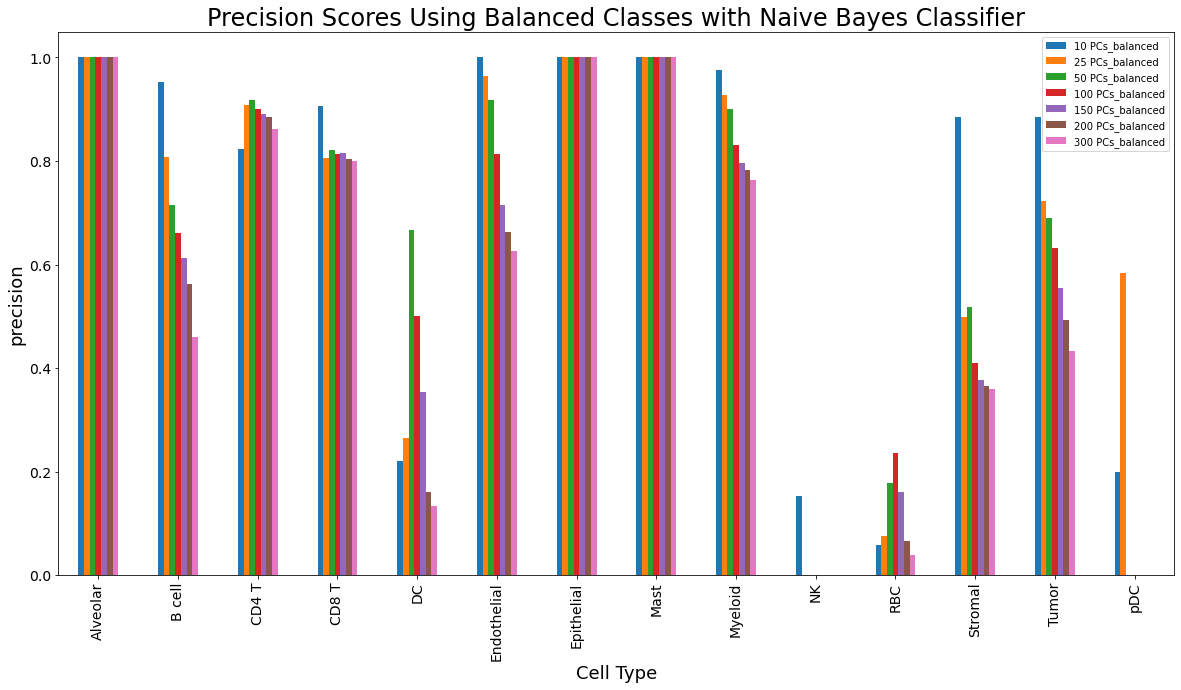

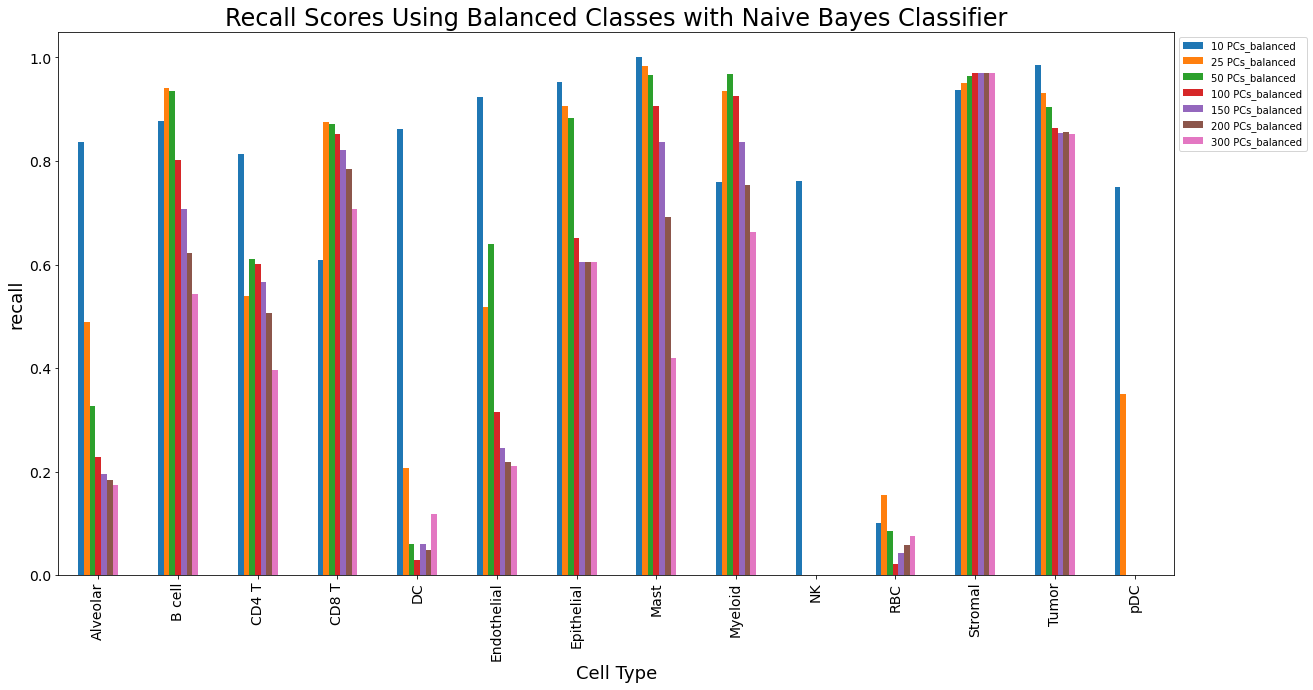

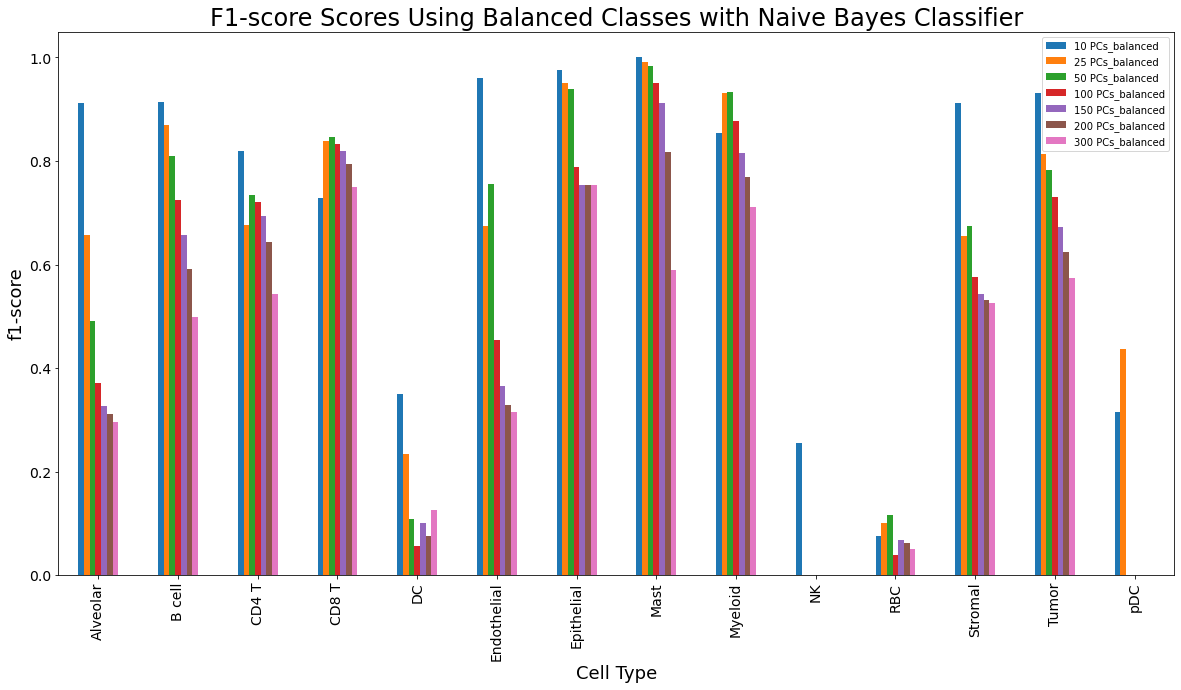

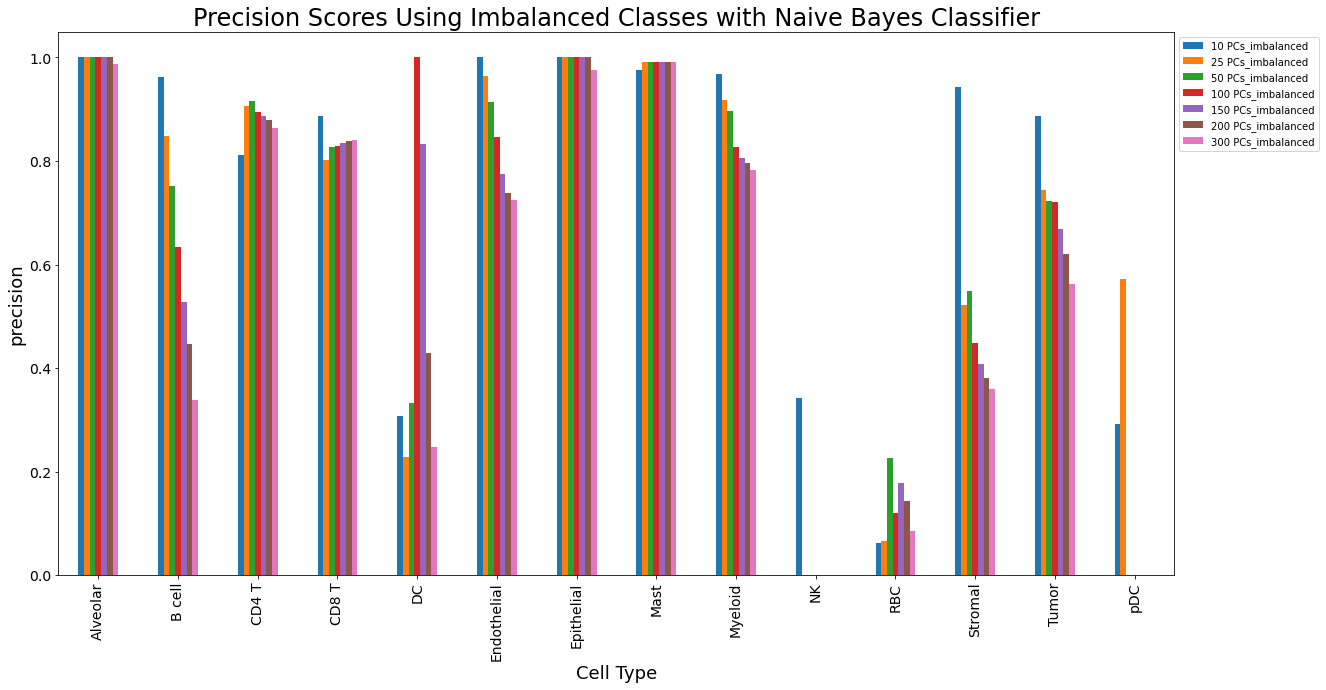

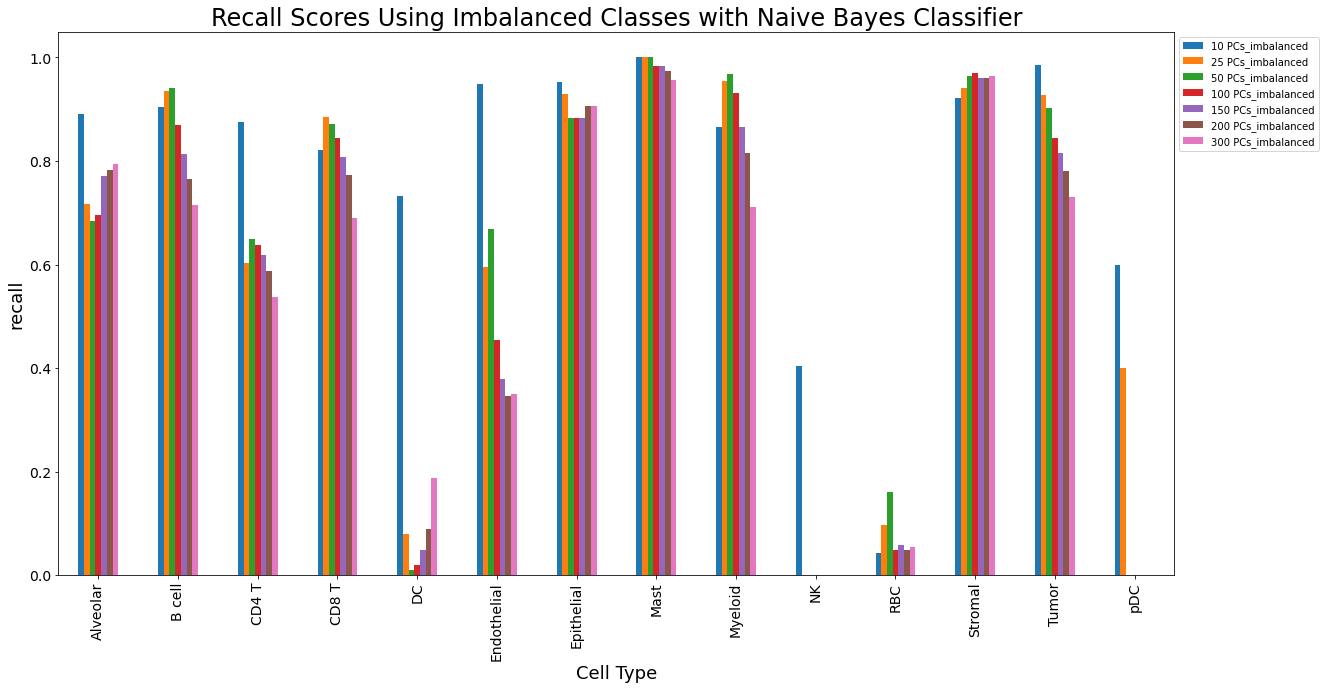

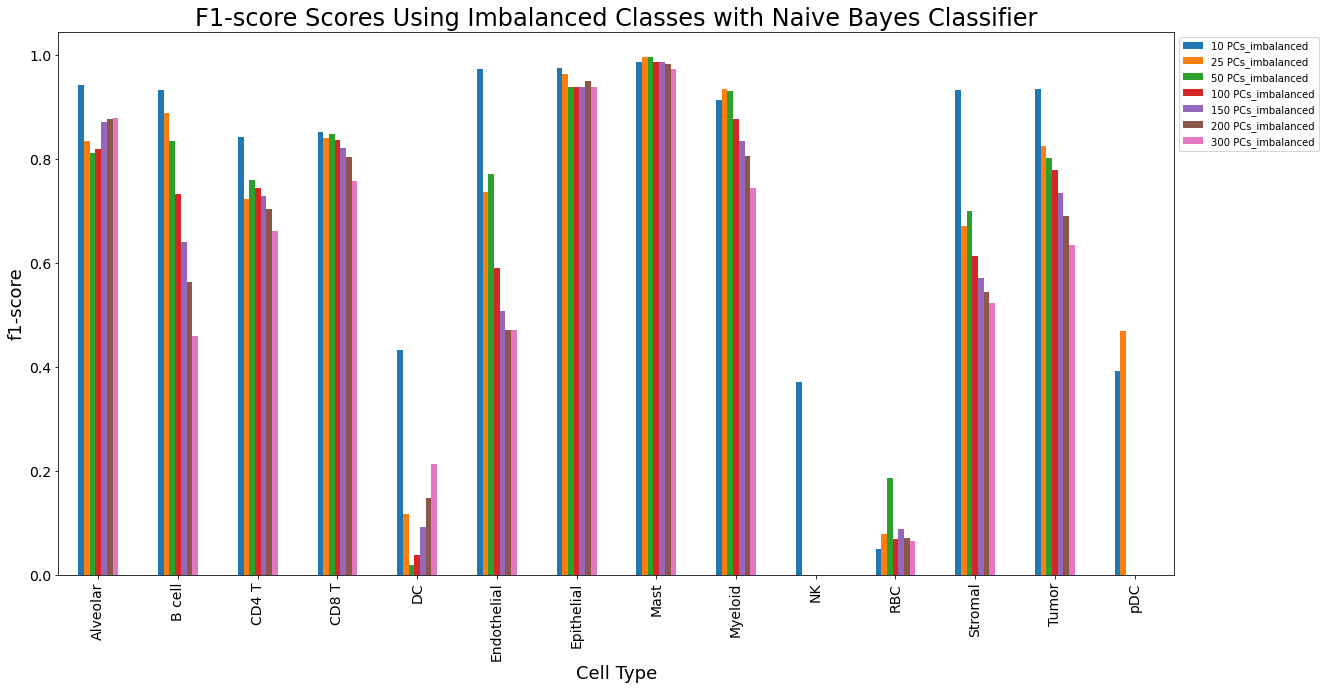

In [14]:
from sklearn.naive_bayes import GaussianNB

nb_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    nb = GaussianNB().fit(X_train, y_train['type'])
    nb_dataframes.append(generate_class_dataframe(nb, "Naive Bayes Classifier", key, X_test, y_test))
generate_summary_bar_plots(nb_dataframes, "Naive Bayes Classifier", pc_train_test_dict.keys())

### Random Forest

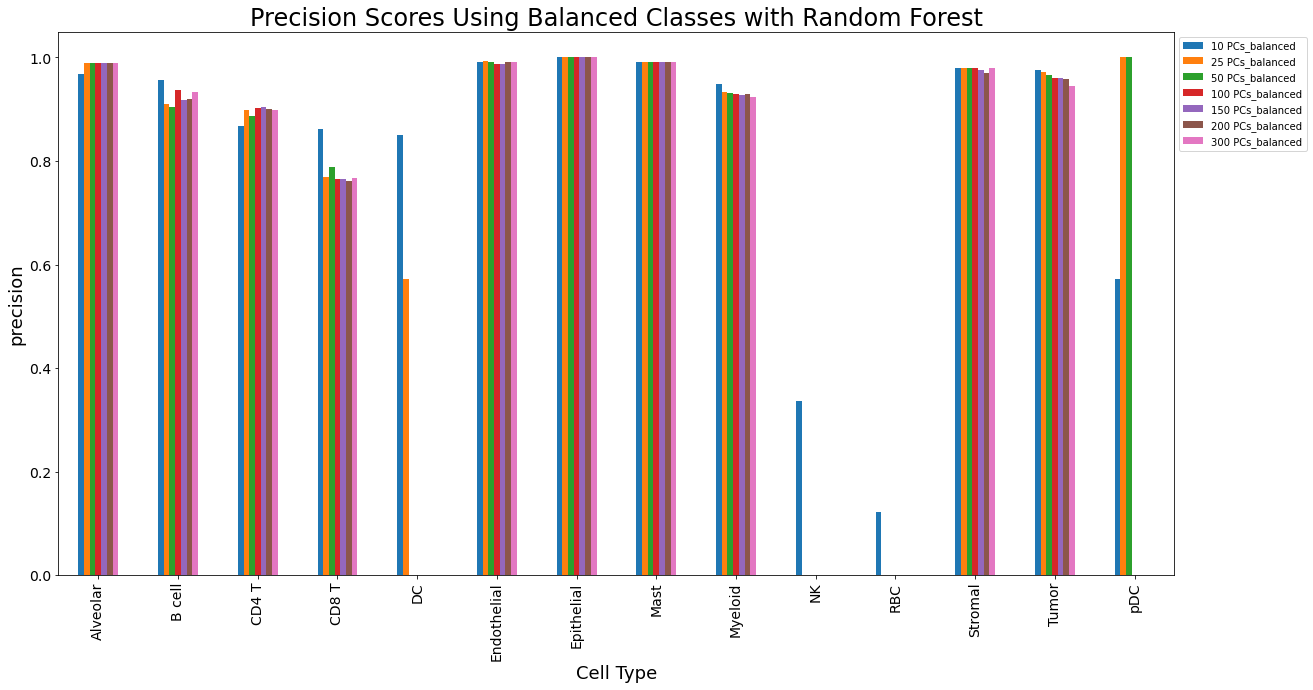

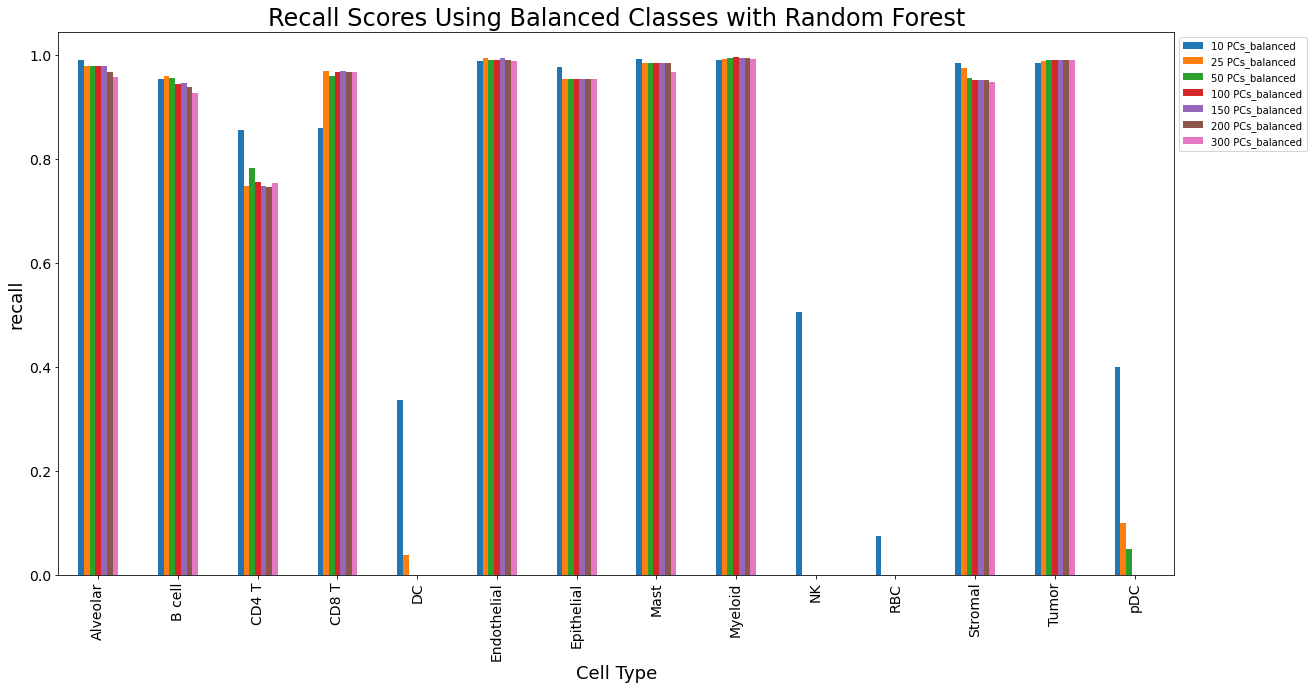

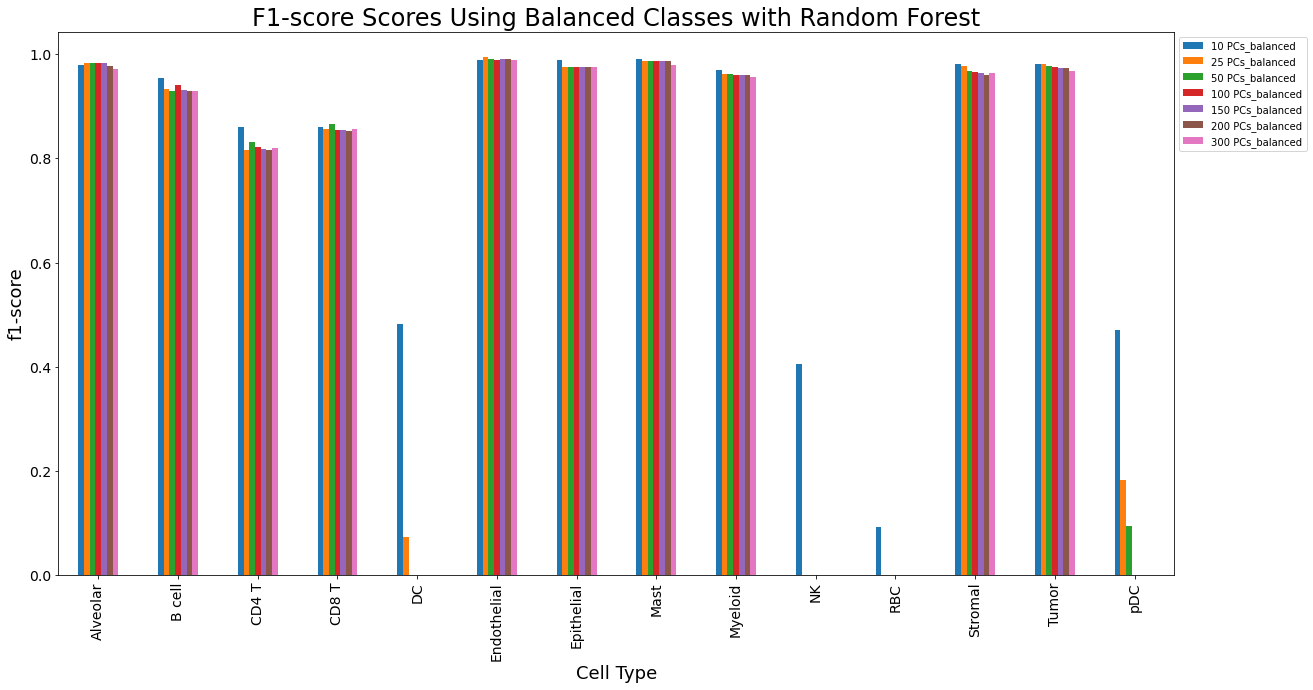

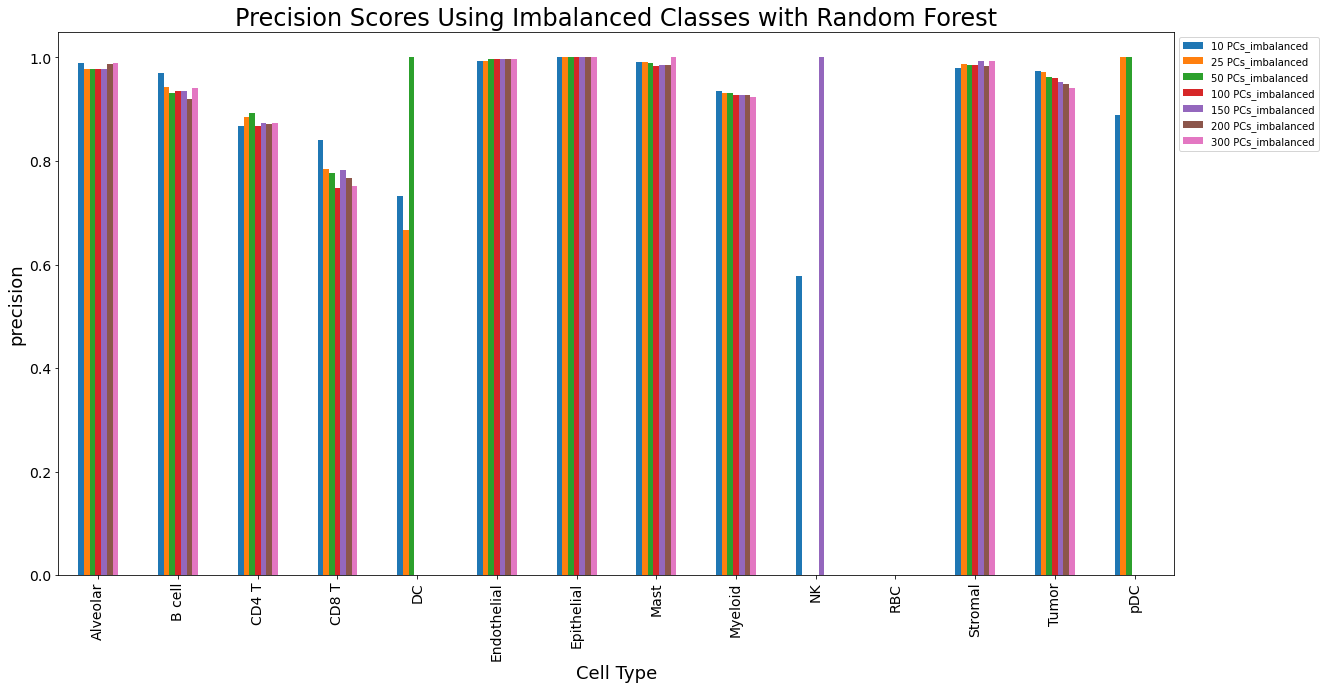

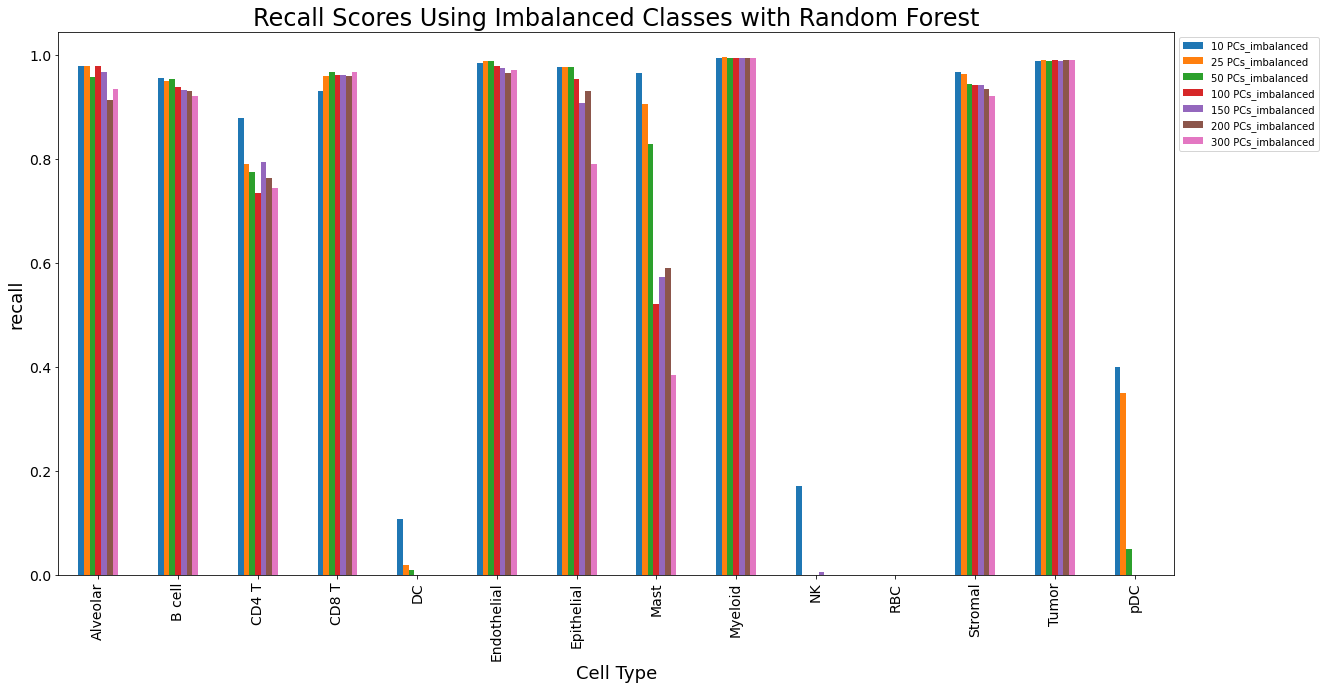

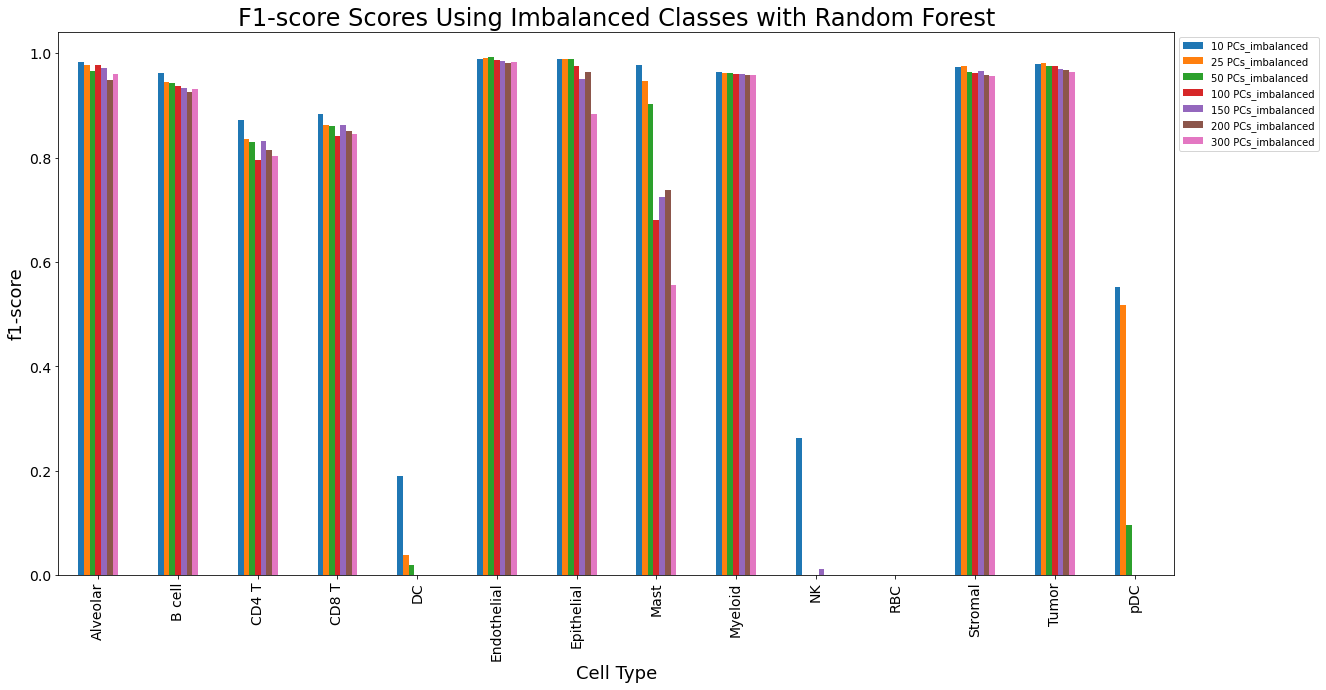

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    random_forest = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    random_forest_dataframes.append(generate_class_dataframe(random_forest, "Random Forest", key, X_test, y_test))
generate_summary_bar_plots(random_forest_dataframes, "Random Forest", pc_train_test_dict.keys())

### Neural Network

/home/miniebr1/miniconda2/envs/image_processing/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/miniebr1/miniconda2/envs/image_processing/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


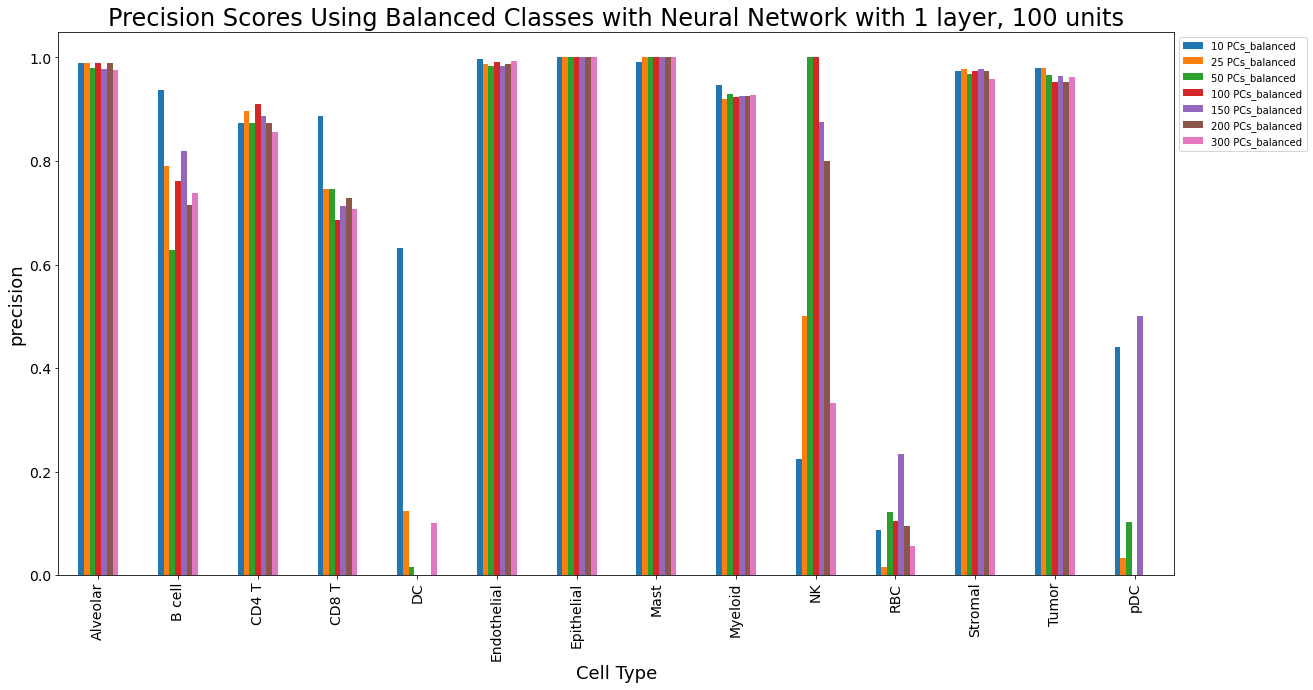

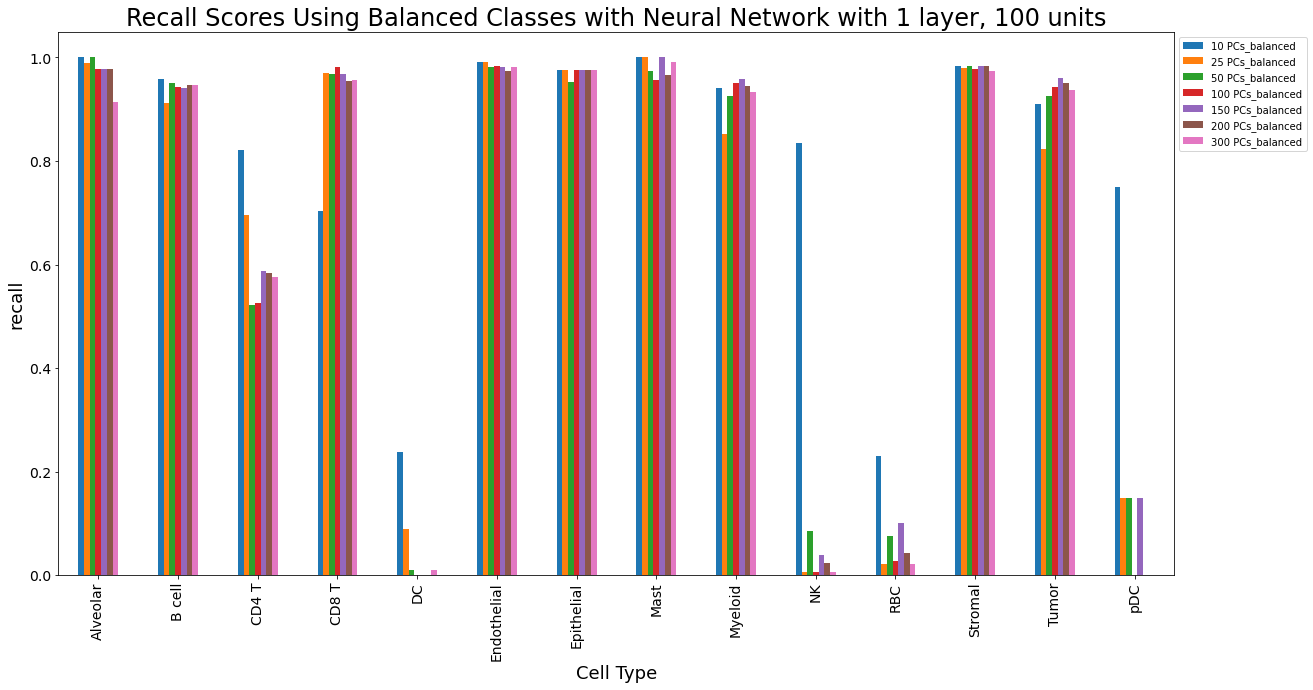

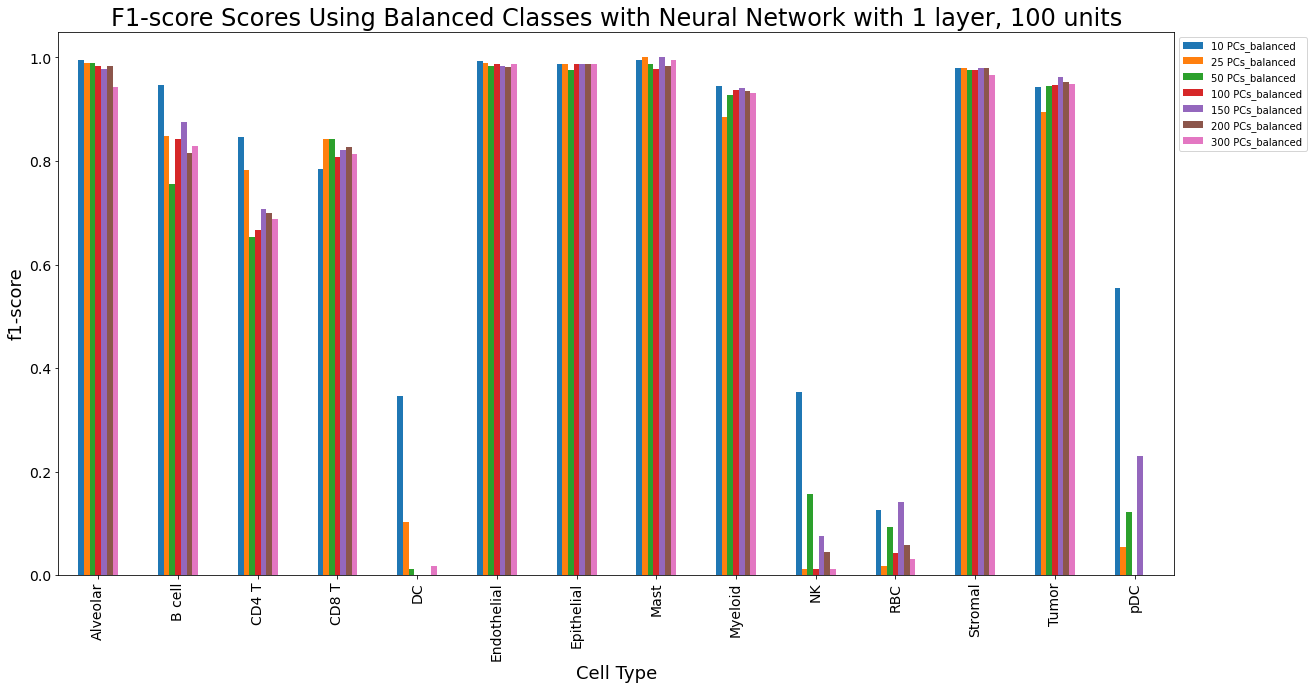

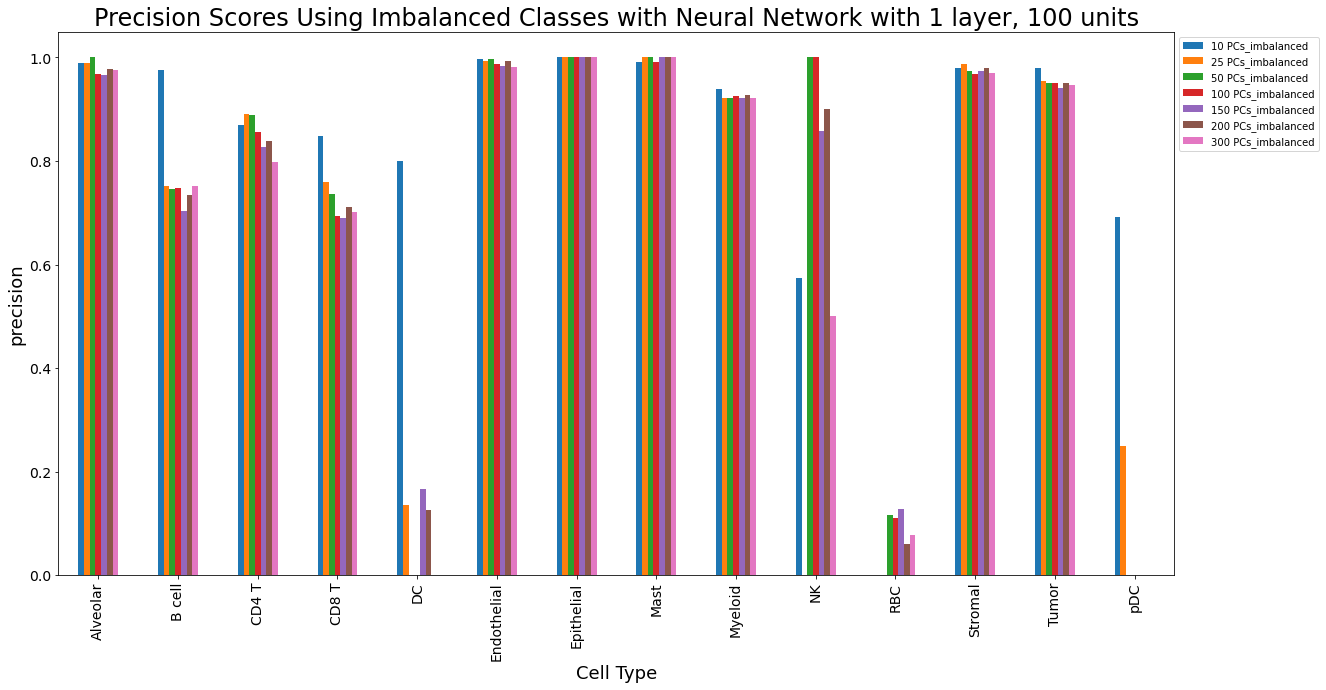

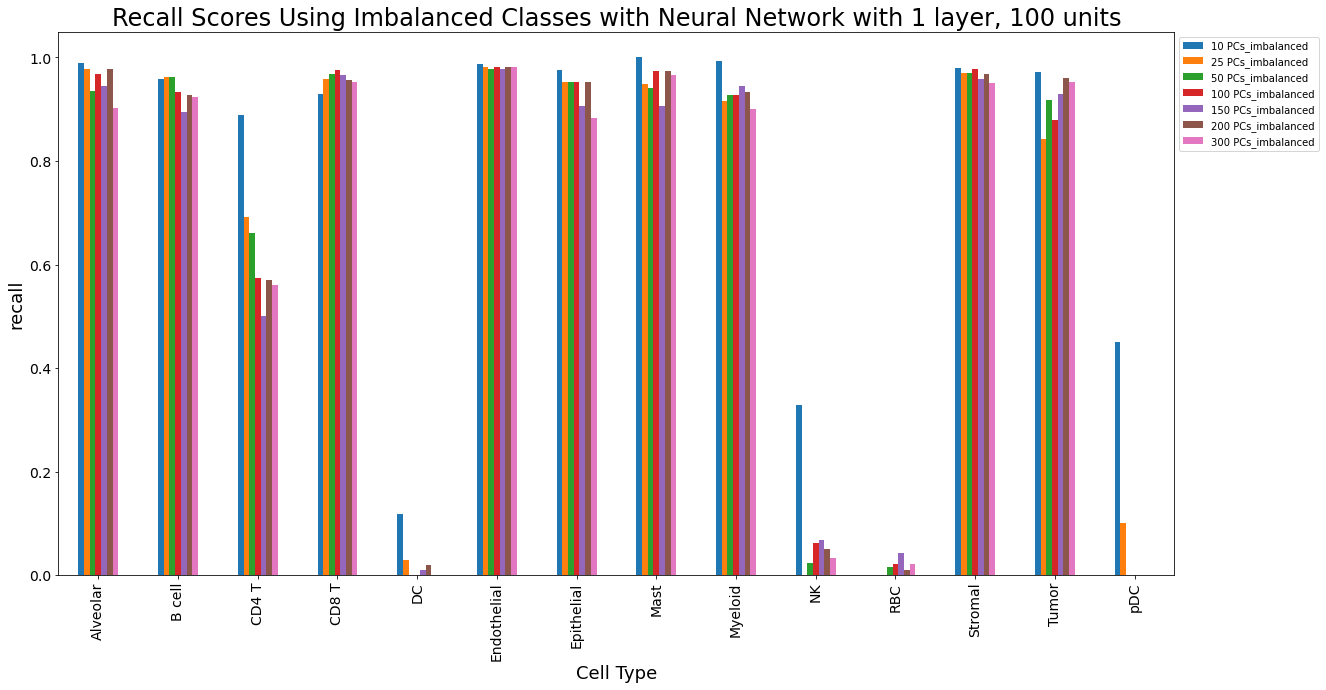

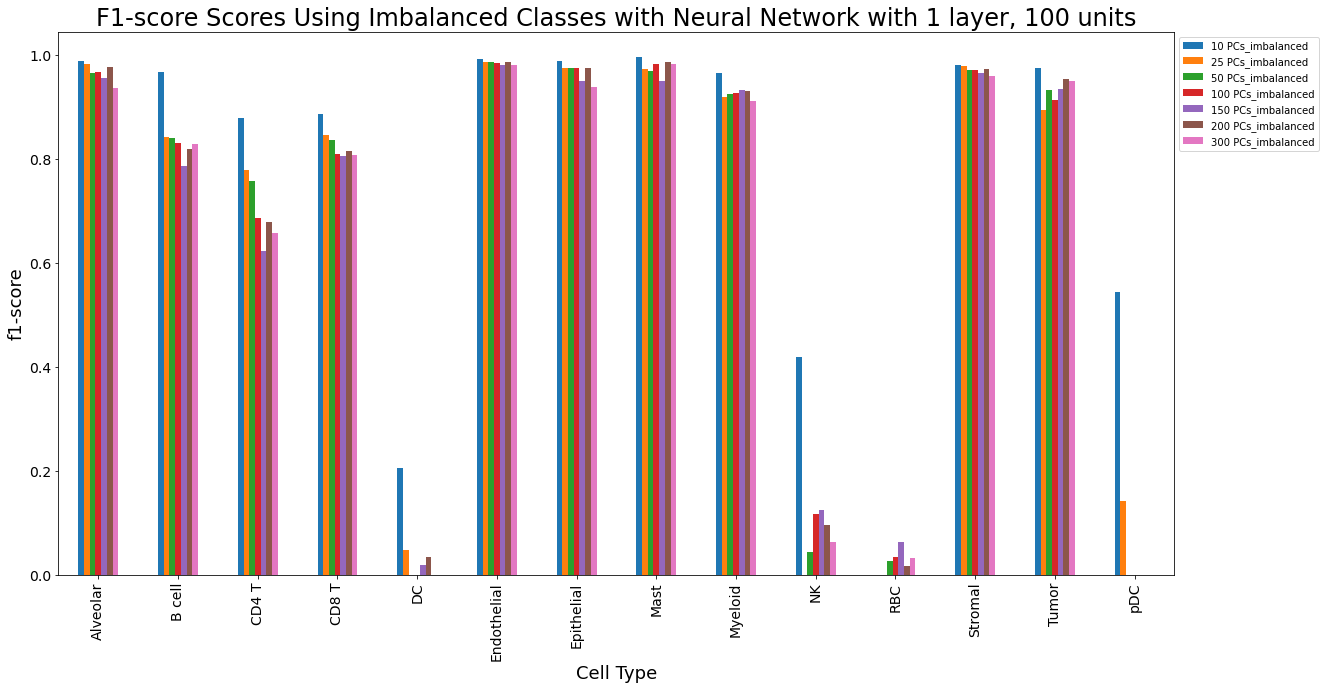

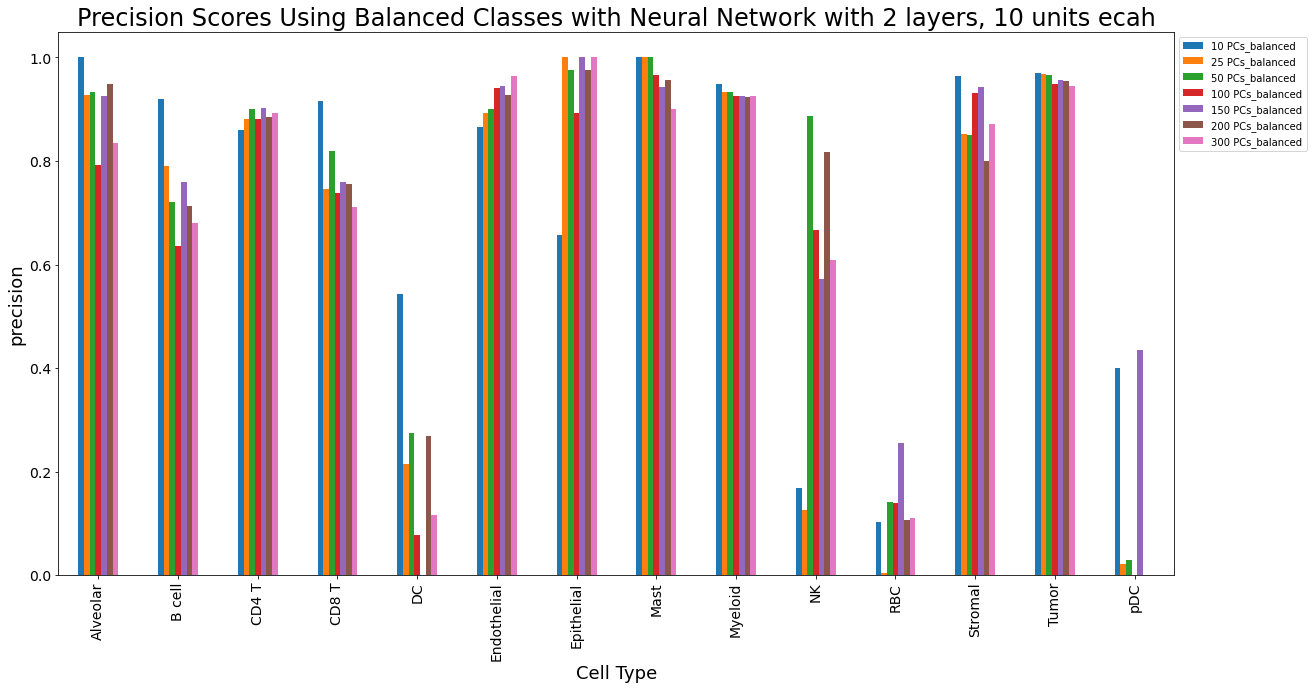

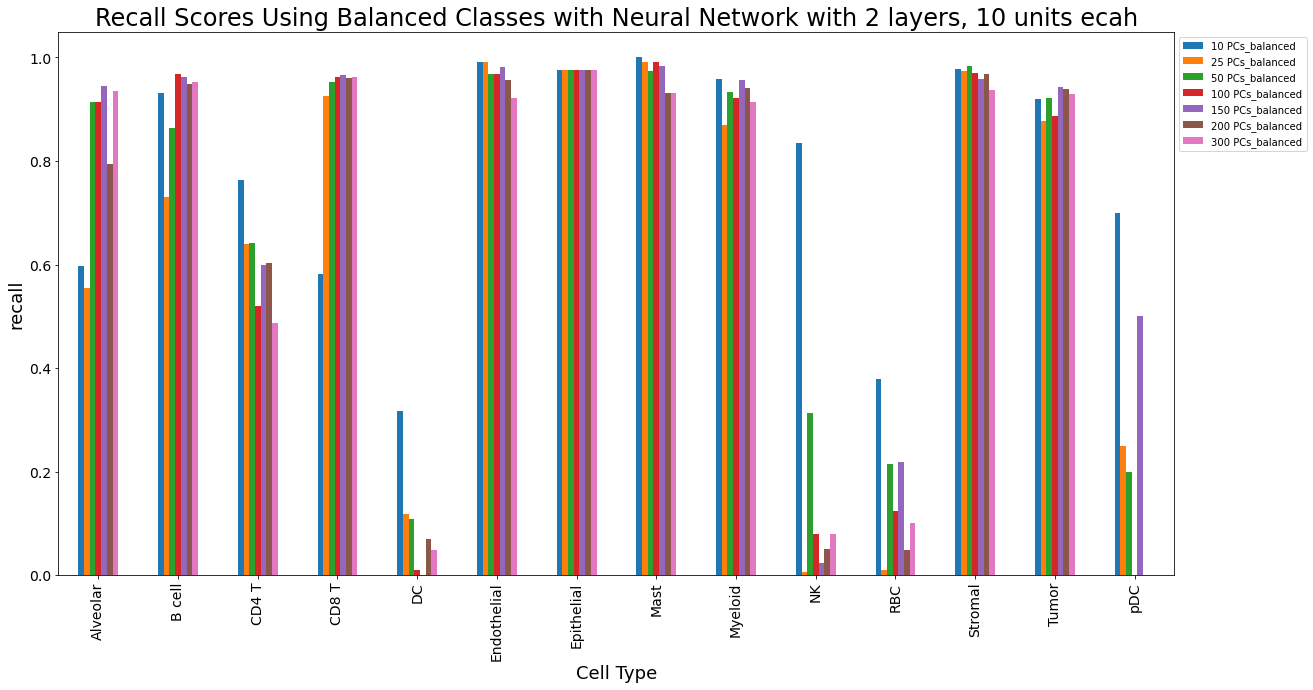

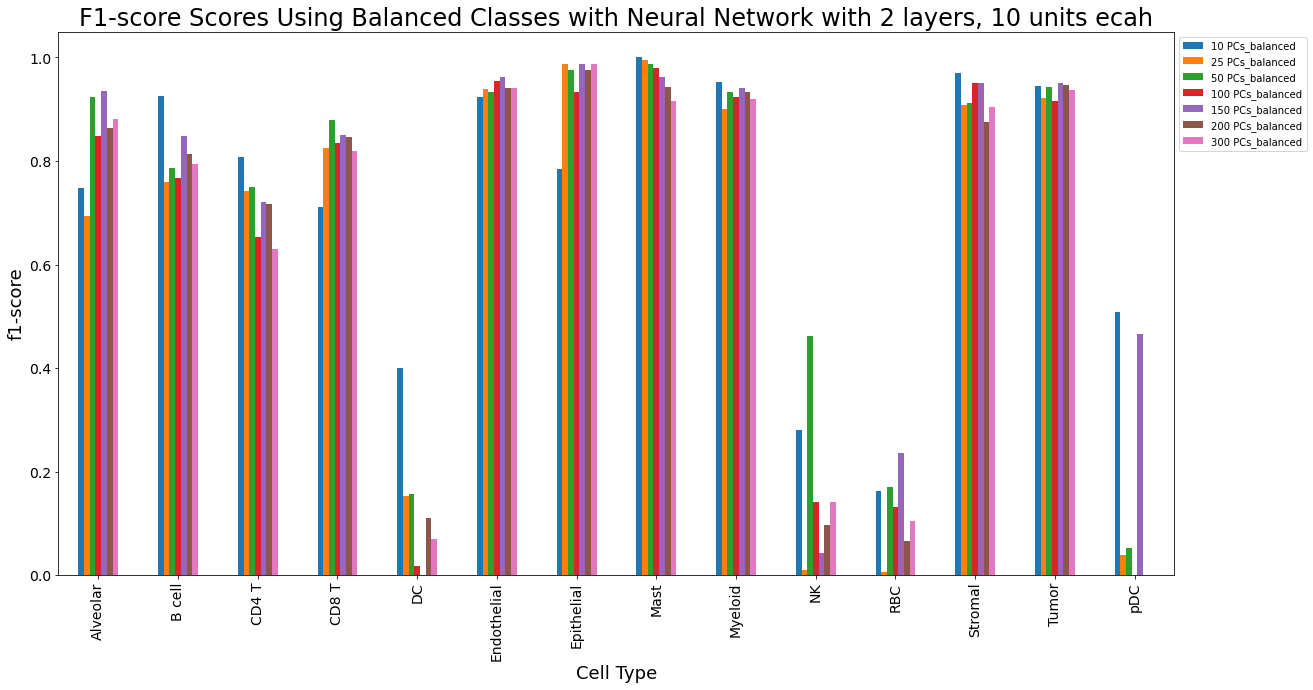

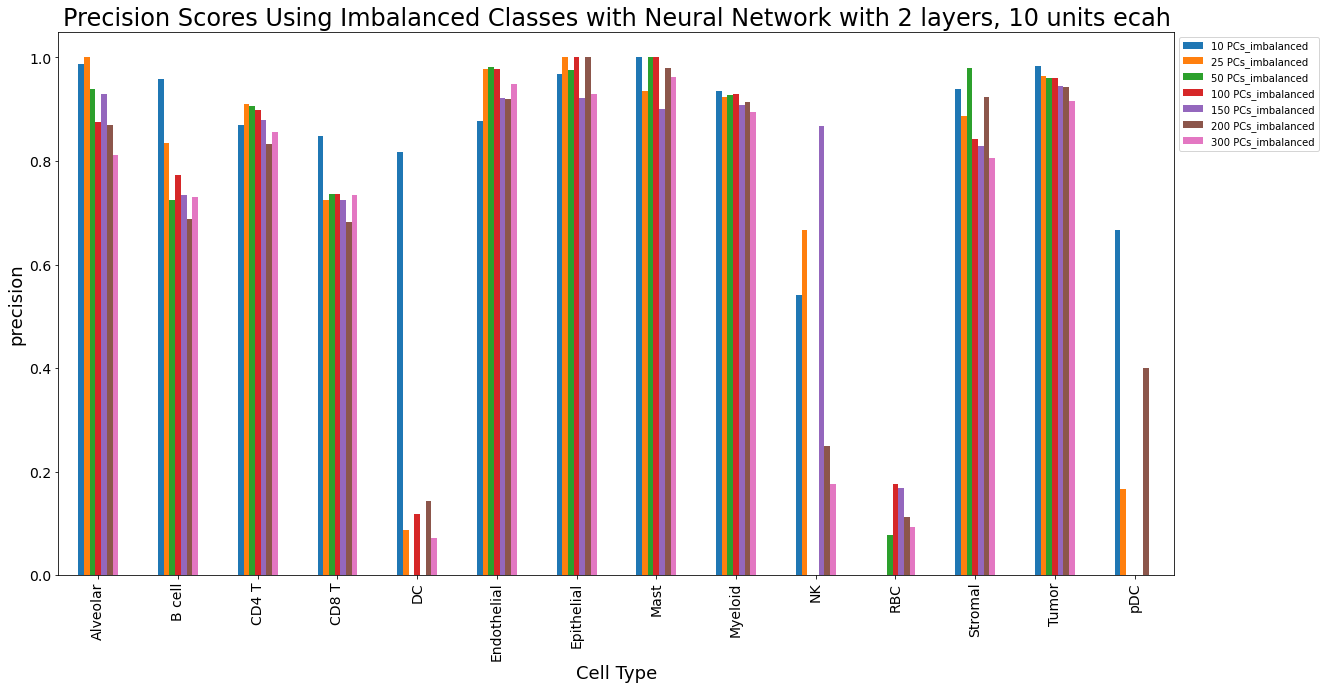

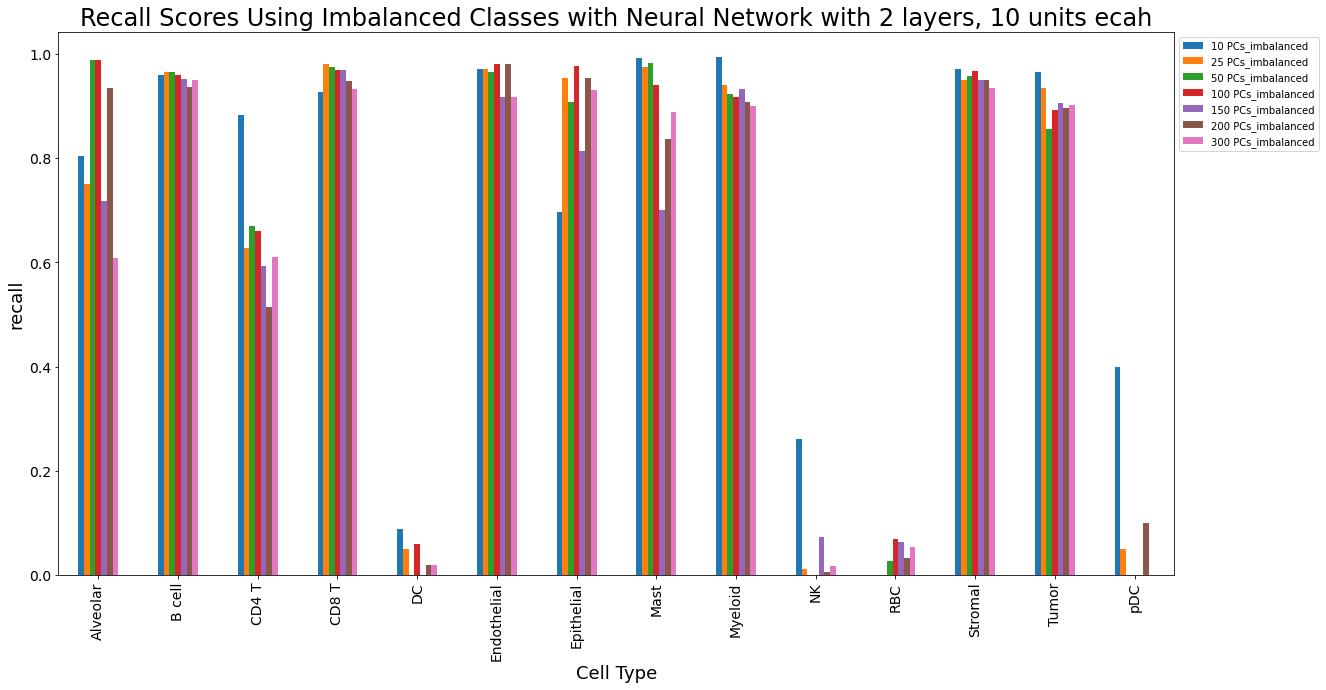

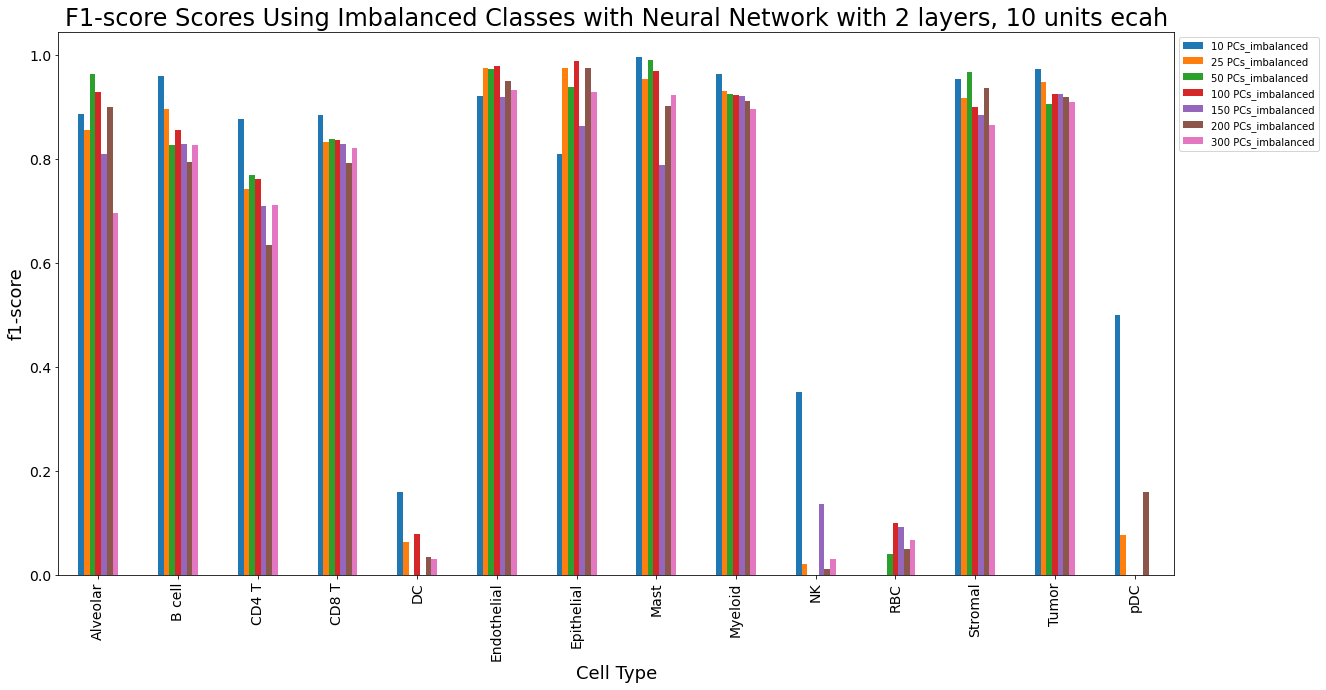

In [16]:
from sklearn.neural_network import MLPClassifier

neural_net_100_dataframes = []
neural_net_2_10_dataframes = []
for key, value in pc_train_test_dict.items():
    X_train, y_train, X_test, y_test = value
    neural_net_100 = MLPClassifier(hidden_layer_sizes=[100], alpha=0.1, random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    neural_net_100_dataframes.append(generate_class_dataframe(neural_net_100, "Neural Network with 1 layer, 100 units", key, X_test, y_test))
    neural_net_2_10 = MLPClassifier(hidden_layer_sizes=[10, 10], alpha=0.1, random_state=RANDOM_SEED).fit(X_train, y_train['type'])
    neural_net_2_10_dataframes.append(generate_class_dataframe(neural_net_2_10, "Neural Network with 2 layers, 10 units each", key, X_test, y_test))
generate_summary_bar_plots(neural_net_100_dataframes, "Neural Network with 1 layer, 100 units", pc_train_test_dict.keys())
generate_summary_bar_plots(neural_net_2_10_dataframes, "Neural Network with 2 layers, 10 units ecah", pc_train_test_dict.keys())

### Combine All Results

In [17]:
all_dataframes = mostfrequent_dataframes + stratified_dataframes + knn_dataframes + svc_dataframes + decisiontree_nomd_dataframes + decisiontree_md_dataframes + gbdt_dataframes + nb_dataframes + random_forest_dataframes + neural_net_100_dataframes + neural_net_2_10_dataframes
final_df = pd.concat(all_dataframes, axis=1)
final_df.head()

Most Frequent Dummy Classifier                           \
                      10 PCs_imbalanced                            
                              precision recall  f1-score support   
Alveolar                       0.000000    0.0  0.000000      92   
B cell                         0.000000    0.0  0.000000     855   
CD4 T                          0.000000    0.0  0.000000    2119   
CD8 T                          0.248141    1.0  0.397617    2503   
DC                             0.000000    0.0  0.000000     101   

                                                                            \
         10 PCs_balanced                          25 PCs_imbalanced          
               precision recall  f1-score support         precision recall   
Alveolar        0.009121    1.0  0.018076      92          0.000000    0.0   
B cell          0.000000    0.0  0.000000     855          0.000000    0.0   
CD4 T           0.000000    0.0  0.000000    2119          0.000000    0.0   
CD8 T           0.000000    0.0  0.000000    2503          0.248141    1.0   
DC              0.000000    0.0  0.000000     101          0.000000    0.0   

          ... Neural Network with 2 layers, 10 units each          \
          ...                            200 PCs_balanced           
          ...                                    f1-score support   
Alveolar  ...                                    0.863905      92   
B cell    ...                                    0.813848     855   
CD4 T     ...                                    0.717013    2119   
CD8 T     ...                                    0.845734    2503   
DC        ...                                    0.110236     101   

                                                                          \
         300 PCs_imbalanced                             300 PCs_balanced   
                  precision    recall  f1-score support        precision   
Alveolar           0.811594  0.608696  0.695652      92         0.834951   
B cell             0.731115  0.950877  0.826640     855         0.679733   
CD4 T              0.855254  0.610665  0.712555    2119         0.891869   
CD8 T              0.734739  0.932881  0.822038    2503         0.712090   
DC                 0.071429  0.019802  0.031008     101         0.116279   

                                      
                                      
            recall  f1-score support  
Alveolar  0.934783  0.882051      92  
B cell    0.953216  0.793574     855  
CD4 T     0.486550  0.629618    2119  
CD8 T     0.962445  0.818552    2503  
DC        0.049505  0.069444     101  

[5 rows x 616 columns]

In [18]:
final_df.to_excel("data/supervised_learning_output_metrics.xlsx")